<a href="https://colab.research.google.com/github/mafux777/kintusgi-extras/blob/main/Kintsugi_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Let's start with some utilities for substrate for python..

In [1]:
# next line only needed in Google Colaboratory! Otherwise pip install yourself
!pip install substrate-interface

from substrateinterface import SubstrateInterface

kint_substrate = SubstrateInterface(
    url="wss://api-kusama.interlay.io/parachain"
)
ksm_substrate = SubstrateInterface(
    url="wss://kusama-rpc.dwellir.com"
)

def convert_kint_to_ksm(kint):
    universal = kint_substrate.ss58_decode(kint)
    kusama = ksm_substrate.ss58_encode(universal)
    return kusama

def convert_ksm_to_kint(k):
    universal = ksm_substrate.ss58_decode(k)
    kint = kint_substrate.ss58_encode(universal)
    return kint



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 182 kB 5.3 MB/s 
     |████████████████████████████████| 856 kB 44.9 MB/s 
     |████████████████████████████████| 142 kB 42.5 MB/s 
     |████████████████████████████████| 1.0 MB 44.7 MB/s 
     |████████████████████████████████| 1.0 MB 42.9 MB/s 
     |████████████████████████████████| 243 kB 52.1 MB/s 
     |████████████████████████████████| 54 kB 2.8 MB/s 
     |████████████████████████████████| 89 kB 8.2 MB/s 
     |████████████████████████████████| 1.2 MB 45.9 MB/s 
     |████████████████████████████████| 2.3 MB 42.8 MB/s 
     |████████████████████████████████| 1.6 MB 37.9 MB/s 
     |████████████████████████████████| 62 kB 574 kB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
ERROR: pip's dependency resolver does not current

Let's analyze Kintsugi's vaults and early investors. For that, we will use several subsquids.

Kintsugi-X is a subsquid built by the Kintsugi-X team for the purpose of analysing transfers.

In [2]:
import requests
import json
import pandas as pd

kintsugi = "https://api-kusama.interlay.io/graphql/graphql"
kusama = "https://app.gc.subsquid.io/beta/kusama-explorer/v1/graphql"
kintsugi_x = "https://app.gc.subsquid.io/beta/kintsugi-x/v4/graphql"


Let's check block production times in kintsugi...

In [3]:
blocks = """
query OracleQuery {
  oracleUpdates(orderBy: timestamp_DESC, where: {typeKey_eq: "KSM"}) {
    timestamp
    height {
      absolute
    }
    typeKey
  }
}
"""

In [4]:
r = requests.post(kintsugi, json={"query" : blocks}).json()
blocks_df = pd.json_normalize(r['data']['oracleUpdates'])
blocks_df.index = blocks_df.timestamp.apply(pd.to_datetime)
blocks_df['height.absolute'] = blocks_df['height.absolute'].astype(float)
a = blocks_df['height.absolute'].resample("4h").ohlc()
a

,open,high,low,close
timestamp,,,,
2022-03-01 12:00:00+00:00,540388.0,540388.0,540388.0,540388.0
2022-03-01 16:00:00+00:00,540453.0,541080.0,540453.0,541080.0
2022-03-01 20:00:00+00:00,541149.0,541693.0,541149.0,541693.0
2022-03-02 00:00:00+00:00,541765.0,542318.0,541765.0,542318.0
2022-03-02 04:00:00+00:00,542390.0,543006.0,542390.0,543006.0
...,...,...,...,...
2022-07-20 00:00:00+00:00,1172376.0,1173016.0,1172376.0,1173016.0
2022-07-20 04:00:00+00:00,1173095.0,1173712.0,1173095.0,1173712.0
2022-07-20 08:00:00+00:00,1173790.0,1174489.0,1173790.0,1174489.0


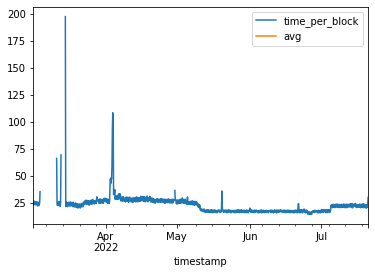

In [5]:
a['blocks'] = (a.close-a.open)
a['time_per_block'] = (4*60*60) / a.blocks
a['avg'] = a['time_per_block'].mean()
a.loc[:, ['time_per_block', 'avg']].plot()


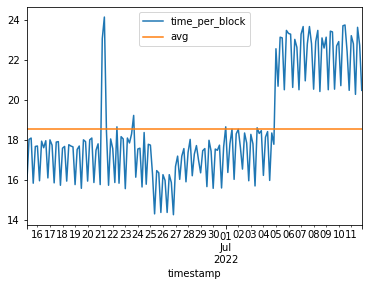

In [6]:
b = a.loc[(a.index>'2022-06-15')&(a.index<'2022-07-12'), ['time_per_block', 'avg']]
b['avg'] = b['time_per_block'].mean()
b.plot()

In [7]:
b

,time_per_block,avg
timestamp,,
2022-06-15 04:00:00+00:00,15.964523,18.547748
2022-06-15 08:00:00+00:00,18.022528,18.547748
2022-06-15 12:00:00+00:00,18.090452,18.547748
2022-06-15 16:00:00+00:00,15.824176,18.547748
2022-06-15 20:00:00+00:00,17.668712,18.547748
...,...,...
2022-07-11 04:00:00+00:00,22.820919,18.547748
2022-07-11 08:00:00+00:00,20.281690,18.547748
2022-07-11 12:00:00+00:00,23.645320,18.547748


Version 4 of the Kintsugi-X squid ignored those token transfers of amount 456621004566 which are related to distributing vault block rewards. It's currently hard coded to the amount but it works.

One of the interesting questions is: do vaults self-mint?

In [8]:
def is_equal(row):
    return row["userParachainAddress"] == row['vault.accountId']


Let's start creating a directory of interesting Kintsugi addresses.
This info comes from the Interlay discord server, "meet the vaults".

In [9]:
kts = {
    "a3eZhSC12zE4D49ir4QkxZwDC3jU6iwNQ953ZZzQsCLTnPJjs": ['Simon Kraus', '@sik'],
    "a3fxS24Bduq8cxT4oV7RQ6q6vfEdSEkaapER75BS4rF7U6Q63": ['Simon Kraus', '@sik'],
    "a3addPTx9ngWGKq3dguw7vs7NA2PimcDUHWJ32HsuoFL74zdo": ['Simon Kraus', '@sik'],
    "a3bccyaV6tCoqaWqByeqvXo5kBbd1m4yCPKyX937HB1APTt7Y": ['rodrigo.barrios', 'hypersphere'],
    "a3bzFrZ5kXYpaaD5NbapUDSfjZPQTWFKGwSbMmGeRAL8BGrCs": ['@boyswan'],
    "a3btcmyVE6ENtWVyHiX9QnorJfKfA2TsSCF43urDeNAWKueH6": ['@seergeist'],
    "a3dh62XsvNmtPAzfwCH9bv34dqPFzjKcWBi5mYM93mKmMt64s": ['@DkA7s'],
    "a3dh7jXhw2q7vqUpEPAb8BeFTNqXXvG9zBf7hsfm3o9hNbjtK": ['@whisperit'],
    "a3aDPraojQvYhVHjyVuYRFXno58EPMjegrY9nubPmpck2X7JS": ['@blinkin', 'chaos DAO'],
    "a3azGTG3qGmUuQckCKjFAhfjfnnRAXmpgV4fPVPziNaA1zCwG": ['@marvel'],
    "a3eKvTxY56smUwHU9vLpw9w5kSqpoPkJskU2tNxUSHAnntQTS": ['@mafux777'],
    "a3cCyigH5pLJXcLKRNGFaBnx3a7diTXq9pPZ1TB8XWgqeCQvW": ['@spazcoin', 'chaos DAO', 'VaaS'],
    "a3baaLbC1JMHJLJ2HwEQMz3S5VuiCWBYy4i66Ziq1vXzmVU6b": ['@spazcoin', 'chaos DAO'],
    "a3fudELrRCjuSyYEPkRAKFQyjzo5YyU228LdqinGsnjBUNB8P": ['@spazcoin', 'chaos DAO', 'VaaS'],
    "a3cCyigH5pLJXcLKRNGFaBnx3a7diTXq9pPZ1TB8XWgqeCQvW": ['@spazcoin', 'chaos DAO'],
    "a3fcMNTjXcJSwAVnTNKwwP7T8XM2bCW7FshsTW2hpUTrdXzed": ['@spazcoin', 'chaos DAO'],
    "a3aPvmjypKaDtjRgYbDL2CCkseYR3SLwvPevL6j7wF67aFtV4": ['@timbotronic'],
    "a3fZSzXxTZYY58BQrfhJx8cDtp4wRdbZ8X4ReF2iUT63y5RcX": ['@0xvault'],
    "a3dJfVzssBJgBmRuMZBre5H71rvawHJoFvFHGz2Aq7Hdt492w": ['@niko'],
    "a3eFe9M2HbAgrQrShEDH2CEvXACtzLhSf4JGkwuT9SQ1EV4ti": ['@paride'],
    "a3cAyFZMgahPoAyWbNRrjX2TnXQtpS3bztCVMNuLNcTYATBte": ['@dan', 'interlay'],
    "a3azPeBMe1EexQvFMd5otaV4q4fPN3Ya5aBQhaChpGzbhLPpe": ['pumpernickel'],
    "a3dMJSmFcqTDpvRPfM2HKn7CHd5uw3G7atogtxXeXru3LGURE": ['@alibaba'],
    "a3cDUVdQi8FqkiUBMjqS3RBWPghRWFXBwjRzKZvmB3MmHLDcP": ['@alibaba'],
    "a3aGT3FRF1WgWtWdi8VmhB3YEJVE6XtrvT41TqcKFxZbuUvS1": ['@warinelly'], # info provided by @quin
    "a3fxCiEXfZJThTpHR5FPT3jngnFWQygAtw1ieDp2w9669v6eN": ['@kbl', 'Kusama Kings & Queens'],
    "a3chQwNk9sxP4WHnm82cD6a5AR2tXJ7bmJ88yZGQp4Ay957PB": ['Lucky Friday', 'LIQUIDATED'],
    "a3esntpLud7yGGrkKnqyueJqmwKwE3ZBoG5ZNyHafirmLLDD3": ['Lucky Friday'],
    "a3fxCiEXfZJThTpHR5FPT3jngnFWQygAtw1ieDp2w9669v6eN": ['Lucky Friday'],
    "a3dCFNgcQsgL4wX6apeaxVLTyRzeCiUdEczyvPcXZ5Dmg5rez": ['Lucky Friday'],
    "a3aVQQpfHH49ACiLzDZP8w8eTA2oW7gvifX7E6dLsBJTBdzVR": ['Lucky Friday'],
}

In [10]:
def add_label_to_list(my_list, label):
  for a in my_list:
    if a not in kts:
      kts[a] = []
    if label not in kts[a]:
      kts[a].append(label)    
  
def enrich_df(df, col):
  df[f'label_{col}'] = df[col].apply(lambda v: "/".join(kts.get(v, [])))

Let's create a query to understand transfers from Kusama (Relay Chain) to Kintsugi. These have to be KSM transfers, because Kusama itself does not handle other assets.
We assume that all of these will end up as collateral. 


In [11]:
to_kintsugi = """
query MyQuery {
  transfers(where: {name_eq: "xcmPallet.reserveTransferAssets", AND: {to: {id_eq: "F7fq1inhrJsYSUkWhyZ3zqtp5K3AKBBjbPWy6VLiRGHipPi"}}}, orderBy: date_DESC) {
    name
    amount
    from {
      id
    }
    date
    to {
      id
    }
  }
}

"""

In [12]:
r = requests.post("https://app.gc.subsquid.io/beta/kusama-explorer/v1/graphql", json={"query" : to_kintsugi}).json()
df_0 = pd.json_normalize(r['data']['transfers'])
df_0['ksm'] = df_0['amount'].apply(lambda x: float(x) / 1e12)
kusama_transfers = df_0.groupby('from.id').agg(dict(ksm="sum", date="max")).sort_values('ksm', ascending=False)
kusama_transfers.reset_index(inplace=True)
kusama_transfers.rename(columns={"from.id": "kusama",
                                 "date": "last_seen"}, inplace=True)
kusama_transfers['kintsugi'] = kusama_transfers.kusama.apply(convert_ksm_to_kint)
kusama_transfers


,kusama,ksm,last_seen,kintsugi
0,GDN8YBtPVRkjR7YtEKMUMXzBdtsNYWW7djdsxcQDqSZSxmM,16500.00000,2022-07-19T00:58:54.022Z,a3drCagyKmK1GQnu4MgDXmbKJxrNPURq6xXdL3JR4xVbceZ9g
1,FLwN2Dko6XYG3MGaGBwRwwj9rN6sqDZK1EWMNRQSTM5vDUB,4003.02000,2022-07-19T02:56:18.994Z,a3cympB1CAv73wR8n3i67jBj3w4qcyiYA9u8CWiE5B7W97phW
2,CrZxfsquEZeXLZUk7Uxdts8NpKz1oc7pdDXwHYCSeJ8SLgW,3460.09420,2022-07-08T04:45:54.016Z,a3aVQQpfHH49ACiLzDZP8w8eTA2oW7gvifX7E6dLsBJTBdzVR
3,HExSfZUFJPkbUxpKQ5jM54TA7ThwfsCRBfgowmzzCcH8rV2,3446.75000,2022-05-12T03:35:18.012Z,a3esntpLud7yGGrkKnqyueJqmwKwE3ZBoG5ZNyHafirmLLDD3
4,Ea9GXVeSWj1vxXutpMPtZAinuACMeWYyVfKHqKrn2gb11kj,1090.57600,2022-07-20T03:30:18.008Z,a3cCyigH5pLJXcLKRNGFaBnx3a7diTXq9pPZ1TB8XWgqeCQvW
...,...,...,...,...
71,D8yhHcbwNuYEJUoSDwyQXVnGJzfGpEpnRq8Qdmkc1Etw8vE,0.05000,2022-04-25T19:23:30.004Z,a3amp9SQ3KCV3ugGJufr9hmH73XUBNhZRdKipZyaRLfPx8dqr
72,DoSsDYsK1a8vMaUC3ZhVzvnpKfPZqbBXXQ5cDssxSPgtNqJ,0.01000,2022-05-24T06:51:00.033Z,a3bSHKNLJgq9ebjMyfVTsoEi7bY8ufiunNRHmmZgYh6Yk5gnz
73,F4w3WyrsywpZp7b1YHPQmNQLvqoGy4oS6EK5fjzfSj5zzUG,0.01000,2022-05-17T08:57:00.106Z,a3chmVfmJFoXLFBu6UzBZi19j89KKNrPQGz81F1YfQ6t9CVuY
74,ERuxDEJ9RvfhtdjmtQMfyUQQgPbppKWTpRz9LetHCND2EZM,0.01000,2022-06-17T21:41:30.004Z,a3c4kQN1jXFWBPGRFFLJXyDFjBts7vhe7JiKgJgTZ1rXGDdmC


So only about 64 accounts moved KSM to Kintsugi (likely all vault owners)

Let's identify all the accounts who crowdloaned to Kintsugi!

In [13]:
crowdloans = """
query CrowloanersKintsugi {
  crowdloans(where: {para: {id_eq: "2092"}}) {
    contributions {
      amount
      timestamp
      account {
        id
        substrateAccount
      }
    }
  }
}
"""
r = requests.post("https://app.gc.subsquid.io/beta/parity-kusama/1/graphql", json={"query" : crowdloans}).json()
crd = pd.json_normalize(r['data']['crowdloans'][0]['contributions'])
crd['ksm'] = crd['amount'].apply(lambda x: float(x) / 1e12)
crowdloans = crd.groupby(['account.id', 'account.substrateAccount']).agg(
    dict(
        ksm=sum,
        timestamp=min
    )
)
crowdloans.describe()

,ksm
count,8013.000000
mean,24.959432
std,486.510228
min,0.100000
25%,0.111000
50%,1.000000
75%,2.100000
max,22688.000000


That is a much higher number of people: more than 8000 wallets. Mean amount of KSM contributed: 25. Let's see how many people covered the top 80% -- it's 1600, which confirms the famous 80/20 rule.

In [14]:
q = crowdloans.ksm.quantile(.8)
top_loaners = crowdloans[crowdloans.ksm>q]
top_loaners.reset_index(inplace=True)
top_loaners.rename(columns={"account.id":"kusama",
                            "timestamp": "first_seen"}, inplace=True)
top_loaners['kintsugi'] = top_loaners.kusama.apply(convert_ksm_to_kint)

top_loaners.loc[:, ['kusama', 'kintsugi', 'ksm', 'first_seen']].sort_values('ksm', ascending=False)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,kusama,kintsugi,ksm,first_seen
643,EwAhYwv7TJ1V8fxchsyZHNyturGYgoxhfEiiEnwCt7bWFjD,a3ca19hjMVGsXAWTU69n9rXAJg8Knea8ZYZ8QsabbwYGehfYx,22688.00000,2021-09-24T10:52:42.022Z
1439,HpofvM4WwTEfiAfD8tJPSoV4EQtUxHCbUK8eSHcweoudWS1,a3fTe858Vtm2kM5xAganUggaoqStQaqboSNCpon6HgJxxpnhW,18517.00000,2021-09-24T10:53:18.003Z
596,EkmdfH2Fc6XgPgDwMjye3Nsdj27CCSi9np8Kc7zYoCL2S3G,a3cPc5p4TdRg3MmTjQoe9wHACQwVdJ5mJzghpUwvfHTMPDXvg,17270.44313,2021-09-21T23:42:36.005Z
520,EVAMXLuZGhXcjPWb3JgX6a5qfPq2FH9usUZNuzW5XNQGvEw,a3c7zog8Lw6H3J7B24VCrpLMQcssM88bkkmNFYFoApBXTU9FC,15001.00000,2021-09-17T06:32:06.005Z
1295,HH5CgPv1RAgQMgpJh6p3NdT9juW5RkTgNTZyY14x3YEEY9W,a3euueqBMPEkC5jUKn8zzLcQmvxP2BK54XGMG8sojghhHS8R1,10000.00000,2021-09-16T11:15:06.007Z
...,...,...,...,...
214,DKHXv2J3o9DWZwuNC8dKkRn4ycpu6ikiUTRnYSc1rAXJxmT,a3ax7z4ojRcijBwjQqe2oczD6rC6Lzz3MZNM7wtFGkWKaWF7N,3.05000,2021-09-25T18:32:24.006Z
851,FfjPRZZNzgvQEJWJes4ojqNpUnP4CQhmvJAh8QCfLutsrL4,a3dJZqaLzkpGS5c61n6mF6ychbhFuA5jJcpBrrUCsQ14x58XX,3.05000,2021-09-25T10:54:48.008Z
1124,GhF5ETmUupvonU6Uzt6HgJntYMsEwbCiiVC14pQqTL4xBGU,a3eL5XPFCrjQSVAFbxSnGav67fkqPLpuoZcNtAQd5a7V89VgS,3.04570,2021-09-24T19:57:06.012Z
105,CuvFiWWHSSdnHEqnyejt1aMdefca1cNBe92rbB5GJ9TtKPu,a3aYkhsHwfG29Tf2MGRYvBFMgQs98ftvy2Y2j1vyjzxJX5ZWd,3.04000,2021-09-24T22:29:36.014Z


In [15]:
redeem_query = """query MyQuery {
  redeems(orderBy: request_timestamp_ASC) {
    id
    request {
      requestedAmountBacking
      timestamp
      height {
        absolute
        active
      }
    }
    userParachainAddress
    vault {
      accountId
      collateralToken
      wrappedToken
    }
    userBackingAddress
    bridgeFee
    btcTransferFee
    collateralPremium
    status
    execution {
      height {
        absolute
        active
      }
      timestamp
    }
    cancellation {
      timestamp
      slashedCollateral
      reimbursed
      height {
        absolute
        active
      }
    }
  }
}
"""


Let's use the official Kintsugi squid to download data about issue requests and redemptions. We have to ignore some other relevant ways that affect vaults: thefts and liquidations

In [16]:
issue_query = """
query MyQuery {
  issues(orderBy: request_timestamp_DESC, limit: 10000, offset: 0) {
    id
    request {
      amountWrapped
      bridgeFeeWrapped
      timestamp
      height {
        absolute
        active
      }
    }
    userParachainAddress
    vault {
      accountId
      collateralToken
      wrappedToken
    }
    vaultBackingAddress
    vaultWalletPubkey
    griefingCollateral
    status
    refund {
      amountPaid
      btcAddress
      btcFee
      executionHeight {
        absolute
        active
      }
      executionTimestamp
      id
      requestHeight {
        absolute
        active
      }
      requestTimestamp
    }
    execution {
      height {
        absolute
        active
      }
      amountWrapped
      bridgeFeeWrapped
      timestamp
    }
    cancellation {
      timestamp
      height {
        absolute
        active
      }
    }
  },
}
"""

In [17]:
# Obtain a list of all redemptions and summarize them a bit
r = requests.post(kintsugi, json={"query" : redeem_query}).json()
df_1 = pd.json_normalize(r['data']['redeems'])
df_1['btc'] = df_1['request.requestedAmountBacking'].apply(lambda x: float(x) / -1e8)
df_1['self'] = df_1.apply(is_equal, axis=1)
df_1['action'] = "redeem"

# Obtain a list of all issue executions and summarize them a bit
# issue_query = get_query_text_from_file("issue")
r = requests.post(kintsugi, json={"query" : issue_query}).json()
df_2 = pd.json_normalize(r['data']['issues'])
df_2['btc'] = df_2['request.amountWrapped'].apply(lambda x: float(x) / 1e8)
df_2['self'] = df_2.apply(is_equal, axis=1)
df_2['action'] = "issue"

cols_1 = set(df_1.columns) - set(df_2.columns)
cols_2 = set(df_2.columns) - set(df_1.columns)


The 80% quantile gives us the accounts responsible for 80% of the issues & redemptions

In [18]:
redeems = df_1.groupby('userParachainAddress').agg({'btc':sum}).sort_values('btc', ascending=True)
redeems['btc'] = redeems.btc.apply(lambda x: -x)
q = redeems.btc.quantile(.8)
top_redeemers = redeems[redeems.btc>q].index
add_label_to_list(top_redeemers, 'Top Redeemer')
redeems['btc'] = redeems.btc.apply(lambda x: -x)


In [19]:
issues = df_2.groupby('userParachainAddress').agg({'btc':sum}).sort_values('btc', ascending=False)
q = issues.btc.quantile(.8)
top_issues = issues[issues.btc>q].index
add_label_to_list(top_issues, 'Top Issuer')



In [20]:
issues[issues.btc>q].btc.sum()

57.776743919999994

In [21]:
self_issuers = df_2[df_2.self==True]


Let's consolidate this info and merge the two dataframes so we can net out the issue requests and the redeem requests.

In [22]:
merged_df = pd.concat([
    df_1.loc[df_1.status=='Completed', ['vault.accountId', 'btc', 'request.timestamp', 'self']],
    df_2.loc[df_2.status=='Completed', ['vault.accountId', 'btc', 'request.timestamp', 'self']],
                       ]).sort_values('request.timestamp')
# apportion BTC to self or other
merged_df['btc_self'] = merged_df.apply(lambda b: b.btc if b.self else 0, axis=1)
merged_df['btc_other'] = merged_df.apply(lambda b: b.btc if not b.self else 0, axis=1)
# add up the BTC depending on self/other
biggest_vaults = merged_df.groupby('vault.accountId').agg(dict(btc_self='sum', btc_other='sum', btc='sum')).sort_values('btc', ascending=False)
biggest_vaults['social'] = biggest_vaults.apply(lambda b: True if b.btc_self<0.2*b.btc else False, axis=1)
biggest_vaults['selfish'] = biggest_vaults.apply(lambda b: True if b.btc_self>0.8*b.btc else False, axis=1)
add_label_to_list(biggest_vaults.loc[biggest_vaults.social].index, 'Social')
add_label_to_list(biggest_vaults.loc[biggest_vaults.selfish].index, 'Selfish')


biggest_vaults.reset_index(inplace=True)
enrich_df(biggest_vaults, "vault.accountId")
total_btc = biggest_vaults.btc.sum()
biggest_vaults['share'] = biggest_vaults.btc.apply(lambda btc: f"{btc/total_btc:.1%}")


In [23]:
vaults = biggest_vaults.reset_index()
del vaults['index']
vaults = vaults.rename(columns={"vault.accountId":"vault"})
add_label_to_list(list(vaults.vault.iloc[0:20]), "Top 20 Vault")
add_label_to_list(list(vaults.vault.iloc[20:]), "Vault")
add_label_to_list(list(vaults.vault.loc[vaults.vault.isin(self_issuers.userParachainAddress)].iloc[0:20]), "Self Issuer")
enrich_df(vaults, 'vault')
vaults.iloc[0:25]

,vault,btc_self,btc_other,btc,social,selfish,label_vault.accountId,share,label_vault
0,a3drCagyKmK1GQnu4MgDXmbKJxrNPURq6xXdL3JR4xVbceZ9g,0.898650,12.456052,13.354702,True,False,Top Issuer/Social,42.1%,Top Issuer/Social/Top 20 Vault/Self Issuer
1,a3esntpLud7yGGrkKnqyueJqmwKwE3ZBoG5ZNyHafirmLLDD3,4.374950,0.071174,4.446124,False,True,Lucky Friday/Top Redeemer/Top Issuer/Selfish,14.0%,Lucky Friday/Top Redeemer/Top Issuer/Selfish/T...
2,a3cympB1CAv73wR8n3i67jBj3w4qcyiYA9u8CWiE5B7W97phW,0.000000,2.167583,2.167583,True,False,Social,6.8%,Social/Top 20 Vault
3,a3aGT3FRF1WgWtWdi8VmhB3YEJVE6XtrvT41TqcKFxZbuUvS1,-0.098253,1.438745,1.340492,True,False,@warinelly/Social,4.2%,@warinelly/Social/Top 20 Vault
4,a3dqzCRPDD9gwrXZ63FBa6hX2q6DsMcUNWPooK2mNNwTDqajq,0.744558,0.183030,0.927588,False,True,Top Redeemer/Top Issuer/Selfish,2.9%,Top Redeemer/Top Issuer/Selfish/Top 20 Vault/S...
5,a3bkRMWVb3C3JyXVFvfR5Brq435C6eqMr42YhA759JyKTzRzQ,-1.738186,2.610267,0.872081,True,False,Top Redeemer/Social,2.8%,Top Redeemer/Social/Top 20 Vault/Self Issuer
6,a3eKvTxY56smUwHU9vLpw9w5kSqpoPkJskU2tNxUSHAnntQTS,0.827986,-0.004999,0.822987,False,True,@mafux777/Top Issuer/Selfish,2.6%,@mafux777/Top Issuer/Selfish/Top 20 Vault/Self...
7,a3cCyigH5pLJXcLKRNGFaBnx3a7diTXq9pPZ1TB8XWgqeCQvW,0.474723,0.271054,0.745777,False,False,@spazcoin/chaos DAO/Top Redeemer/Top Issuer,2.4%,@spazcoin/chaos DAO/Top Redeemer/Top Issuer/To...
8,a3aVQQpfHH49ACiLzDZP8w8eTA2oW7gvifX7E6dLsBJTBdzVR,1.076339,-0.455160,0.621179,False,True,Lucky Friday/Top Redeemer/Top Issuer/Selfish,2.0%,Lucky Friday/Top Redeemer/Top Issuer/Selfish/T...
9,a3fxCiEXfZJThTpHR5FPT3jngnFWQygAtw1ieDp2w9669v6eN,1.166603,-0.546023,0.620579,False,True,Lucky Friday/Top Redeemer/Top Issuer/Selfish,2.0%,Lucky Friday/Top Redeemer/Top Issuer/Selfish/T...


Now comes the time to analyse transfers from Kintsugi to Kintsugi, Karura and Moonriver.

In [24]:
kintsugix_query="""
query MyQuery {
  transfers(orderBy: timestamp_DESC) {
    amount
    from {
      karura
      kintsugi
      kusama
      moonriver
      id
    }
    fromChain
    timestamp
    to {
      id
      karura
      kintsugi
      kusama
      moonriver
    }
    toChain
    token
  }
}

"""

In [25]:
r = requests.post(kintsugi_x, json={"query" : kintsugix_query}).json()
xtoken_transfers = pd.json_normalize(r['data']['transfers'])


In [26]:
master_t = dict(
    KSM = 1e12,
    BTC = 1e8,
    KBTC = 1e8,
    KINT = 1e12,
)

def fix_currency(row):
    token = row['token']
    divisor = master_t.get(token, 1.0)
    row[token.lower()] = float(row.get('amount', 0.0)) / divisor
    return row



In [27]:
xtoken_transfers.rename(columns={"from.id":"from_id", "to.id":"to_id"}, inplace=True)
xtoken_transfers = xtoken_transfers.apply(fix_currency, axis=1)


There are a few accounts involved in crowdloans and other "shenanigans". Let's label them, too. 

In [28]:
shenanigans = xtoken_transfers.loc[xtoken_transfers.toChain==2092].groupby('from_id').agg(dict(kint=sum, to_id='nunique'))
shenanigans.sort_values('to_id', ascending=False).iloc[0:20]

,kint,to_id
from_id,,
a3aWepSsLfy67vUAAaKCiSnCj7G72feeTCgfKCBLivBWWTdFW,219835.650599,668
a3drECEeNJTEfPkMYCu1njch4tmMK1msjjMPbFsF7PSe5Qn5D,8549.272728,477
a3bkd4Z7FSnAVABG9JJV8UyESACpKgretzxMbYx7zLTLoVj2p,66751.972010,193
a3cUcEFSfpaK8spLYmzshHq1XcmyMtrJf66R1r84ngdQFiaXC,56302.075438,121
a3cvxyxiBBT88FkVZ7BYyhKPL9sNVdXYk6UBqk8GQnYzrK6xW,6745.682513,101
a3dtigkC2uf411XjMBN4KE9WSaNQUV3TxhkoRgYtj2VRHYHkT,82.154192,18
a3dMJSmFcqTDpvRPfM2HKn7CHd5uw3G7atogtxXeXru3LGURE,510.608800,15
a3btcmyVE6ENtWVyHiX9QnorJfKfA2TsSCF43urDeNAWKueH6,1191.754270,14
a3aPp8Ei4Qm3dTr57rRabVJhFKpGdzdxYkgFFgqVNZ7nqudyw,3.100000,12


That analysis seems to suggest we should label the ones which sent KINT to more than 5 accts as "shenanigans"...


In [29]:
shenanigans_list = shenanigans.loc[shenanigans.to_id>5].index
shenanigans.reset_index(inplace=True)
enrich_df(shenanigans, 'from_id')

add_label_to_list(shenanigans_list, "shenanigans")
enrich_df(shenanigans, 'from_id')


Who are the accounts that have sent KINT or KSM to the top 20 vaults? We shall exclude "shenanigans".

to_id: the top 20 vaults

from_id: the accounts sending KINT excluding shenanigans



In [30]:
from tensorflow.python.profiler import trace
funding_accounts = xtoken_transfers.loc[
                                        (xtoken_transfers.to_id.isin(vaults.iloc[0:20, 0])) & 
                                        ~(xtoken_transfers.from_id.isin(shenanigans_list)) & 
                                        (xtoken_transfers.toChain==2092)
                                        ].groupby(['to_id', 'from_id', 'from.kusama','fromChain']).agg(dict(kint=sum, ksm=sum, timestamp=min))
funding_accounts.reset_index(inplace=True)
funding_accounts.rename(columns=dict(to_id="vault", from_id="daddy"), inplace=True)


Let's label each daddy with his vault

In [31]:
for n, row in funding_accounts.iterrows():
  vault = row['vault'][-5:] # use only last 5 letters
  daddy = row['daddy']
  add_label_to_list([daddy], f'Daddy of {vault}')  
  add_label_to_list([row['vault']], f'{vault}')

In [32]:
add_label_to_list(funding_accounts.daddy, "Likely Vault Owner")
enrich_df(funding_accounts, 'vault')
enrich_df(funding_accounts, 'daddy')
funding_accounts.sort_values('ksm', ascending=False).loc[:, ['label_vault', 'label_daddy', 'kint', 'ksm']].iloc[0:20]


,label_vault,label_daddy,kint,ksm
15,@spazcoin/chaos DAO/Top Redeemer/Top Issuer/To...,Daddy of eCQvW/Likely Vault Owner,0.000000,199.529560
29,Simon Kraus/@sik/Top 20 Vault/Self Issuer/nPJjs,Simon Kraus/@sik/Top Redeemer/Selfish/Vault/Da...,210.000000,110.660000
6,Simon Kraus/@sik/Selfish/Top 20 Vault/Self Iss...,Simon Kraus/@sik/Top Redeemer/Selfish/Vault/Da...,14.900000,91.948160
20,Social/Top 20 Vault/bdxDB,Daddy of bdxDB/Likely Vault Owner,0.000000,59.990000
13,Social/Top 20 Vault/Daddy of Poxg8/rEszH/Likel...,Social/Top 20 Vault/Poxg8/Daddy of rEszH/Likel...,6.803410,50.335594
14,@spazcoin/chaos DAO/Top Redeemer/Top Issuer/To...,Daddy of eCQvW/Likely Vault Owner,0.000000,45.000000
27,Simon Kraus/@sik/Top 20 Vault/Self Issuer/nPJjs,Simon Kraus/@sik/Selfish/Top 20 Vault/Self Iss...,1568.000000,29.000000
2,Lucky Friday/Top Redeemer/Top Issuer/Selfish/T...,Lucky Friday/Top Issuer/Selfish/Top 20 Vault/S...,0.000000,5.000000
5,Simon Kraus/@sik/Selfish/Top 20 Vault/Self Iss...,Top Redeemer/Top Issuer/Daddy of 74zdo/Daddy o...,0.000000,3.110000
28,Simon Kraus/@sik/Top 20 Vault/Self Issuer/nPJjs,Top Redeemer/Top Issuer/Daddy of 74zdo/Daddy o...,0.000000,3.110000


Of the funders, which ones do we know from the KSM analysis?

In [33]:
k = kusama_transfers.loc[kusama_transfers.ksm>200]
add_label_to_list(k.kintsugi, 'K>200')
enrich_df(k, 'kintsugi')
k

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


,kusama,ksm,last_seen,kintsugi,label_kintsugi
0,GDN8YBtPVRkjR7YtEKMUMXzBdtsNYWW7djdsxcQDqSZSxmM,16500.00000,2022-07-19T00:58:54.022Z,a3drCagyKmK1GQnu4MgDXmbKJxrNPURq6xXdL3JR4xVbceZ9g,Top Issuer/Social/Top 20 Vault/Self Issuer/Dad...
1,FLwN2Dko6XYG3MGaGBwRwwj9rN6sqDZK1EWMNRQSTM5vDUB,4003.02000,2022-07-19T02:56:18.994Z,a3cympB1CAv73wR8n3i67jBj3w4qcyiYA9u8CWiE5B7W97phW,Social/Top 20 Vault/97phW/K>200
2,CrZxfsquEZeXLZUk7Uxdts8NpKz1oc7pdDXwHYCSeJ8SLgW,3460.09420,2022-07-08T04:45:54.016Z,a3aVQQpfHH49ACiLzDZP8w8eTA2oW7gvifX7E6dLsBJTBdzVR,Lucky Friday/Top Redeemer/Top Issuer/Selfish/T...
3,HExSfZUFJPkbUxpKQ5jM54TA7ThwfsCRBfgowmzzCcH8rV2,3446.75000,2022-05-12T03:35:18.012Z,a3esntpLud7yGGrkKnqyueJqmwKwE3ZBoG5ZNyHafirmLLDD3,Lucky Friday/Top Redeemer/Top Issuer/Selfish/T...
4,Ea9GXVeSWj1vxXutpMPtZAinuACMeWYyVfKHqKrn2gb11kj,1090.57600,2022-07-20T03:30:18.008Z,a3cCyigH5pLJXcLKRNGFaBnx3a7diTXq9pPZ1TB8XWgqeCQvW,@spazcoin/chaos DAO/Top Redeemer/Top Issuer/To...
5,GcohCErDM7LjUfBkmNqu19CNzRUEp84DQP4nZeUhjrBHqNP,1067.96346,2022-06-12T09:29:30.012Z,a3eFe9M2HbAgrQrShEDH2CEvXACtzLhSf4JGkwuT9SQ1EV4ti,@paride/Social/Vault/K>200
6,HyWvJx6EUsRV7zwtt3m5sfok8Z56cnf2oymLgu9johaLdRh,820.53000,2022-07-18T03:14:42.012Z,a3fcMNTjXcJSwAVnTNKwwP7T8XM2bCW7FshsTW2hpUTrdXzed,@spazcoin/chaos DAO/Top Redeemer/Top Issuer/Se...
7,Cdcb6dodh71D8rCf3sWsokuXGkaS1YKcA7mgGWbDuSrHSFA,814.00000,2022-06-11T17:40:12.018Z,a3aGT3FRF1WgWtWdi8VmhB3YEJVE6XtrvT41TqcKFxZbuUvS1,@warinelly/Social/Top 20 Vault/uUvS1/K>200
8,EcdZSvpYwbhESMviUwYQb9WiZTgnTYrAsRLUf3GmXyzy5dH,811.65000,2022-06-12T18:24:54.010Z,a3cFU1biFvmBCup9SBvqihpvqVmwCtLsT1mK2dzqwWC94AjJw,Top Redeemer/Daddy of ntQTS/Likely Vault Owner...
9,GCE5wFsJX3x3MpPrekqnXe2STTye3gdvxvjX5gSXL5YSZ74,667.50000,2022-07-12T11:10:00.019Z,a3dq4Y63JgLdTijbuL6f25mRMDfwVjw1EmrpRgRV7FzEbdxDB,Social/Top 20 Vault/bdxDB/K>200


In [34]:
add_label_to_list(top_loaners.kintsugi, 'Top Crowdloaner')
enrich_df(top_loaners, 'kintsugi')
top_loaners.sort_values('ksm', ascending=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


,kusama,account.substrateAccount,ksm,first_seen,kintsugi,label_kintsugi
643,EwAhYwv7TJ1V8fxchsyZHNyturGYgoxhfEiiEnwCt7bWFjD,5ERZ3Ec3V6H5jUrWr14vfL1ykKa2k1znFHPyKaWyj5u6mCfs,22688.00000,2021-09-24T10:52:42.022Z,a3ca19hjMVGsXAWTU69n9rXAJg8Knea8ZYZ8QsabbwYGehfYx,Top Crowdloaner
1439,HpofvM4WwTEfiAfD8tJPSoV4EQtUxHCbUK8eSHcweoudWS1,5HKC1c1BtaSJv4MDSS5FVVSUue8egHU296UPFn1fTrbQtTYd,18517.00000,2021-09-24T10:53:18.003Z,a3fTe858Vtm2kM5xAganUggaoqStQaqboSNCpon6HgJxxpnhW,Top Crowdloaner
596,EkmdfH2Fc6XgPgDwMjye3Nsdj27CCSi9np8Kc7zYoCL2S3G,5EF9yLw9dF5bvjrnAevvk61sV8jsPXdXhQyNvwr34zyqHC4W,17270.44313,2021-09-21T23:42:36.005Z,a3cPc5p4TdRg3MmTjQoe9wHACQwVdJ5mJzghpUwvfHTMPDXvg,Top Crowdloaner
520,EVAMXLuZGhXcjPWb3JgX6a5qfPq2FH9usUZNuzW5XNQGvEw,5DyYhD12vugbs5a4pLVdd9D5h57bDaTyTVdozFiYbj9uXow7,15001.00000,2021-09-17T06:32:06.005Z,a3c7zog8Lw6H3J7B24VCrpLMQcssM88bkkmNFYFoApBXTU9FC,Daddy of ceZ9g/Likely Vault Owner/Top Crowdloaner
1295,HH5CgPv1RAgQMgpJh6p3NdT9juW5RkTgNTZyY14x3YEEY9W,5GmTYN43P49kehsNXzHm9RGT19dGGkwHDzcpasj7UFKjVW2J,10000.00000,2021-09-16T11:15:06.007Z,a3euueqBMPEkC5jUKn8zzLcQmvxP2BK54XGMG8sojghhHS8R1,Top Crowdloaner
...,...,...,...,...,...,...
214,DKHXv2J3o9DWZwuNC8dKkRn4ycpu6ikiUTRnYSc1rAXJxmT,5CofsbgRRS8Hkv8TbVKaRo4mvPLb6RuaG6cgPtAeY3x2ZuW9,3.05000,2021-09-25T18:32:24.006Z,a3ax7z4ojRcijBwjQqe2oczD6rC6Lzz3MZNM7wtFGkWKaWF7N,Top Crowdloaner
851,FfjPRZZNzgvQEJWJes4ojqNpUnP4CQhmvJAh8QCfLutsrL4,5FA7j7DgkdfzeaV4Xx41unUNftW9FXbXKYTRJU8FBYhQ8hPf,3.05000,2021-09-25T10:54:48.008Z,a3dJZqaLzkpGS5c61n6mF6ychbhFuA5jJcpBrrUCsQ14x58XX,Top Crowdloaner
1124,GhF5ETmUupvonU6Uzt6HgJntYMsEwbCiiVC14pQqTL4xBGU,5GBdQv7trYp148eeiJ53Piwnjx5dSGn2GLeScQYTMf7aCyok,3.04570,2021-09-24T19:57:06.012Z,a3eL5XPFCrjQSVAFbxSnGav67fkqPLpuoZcNtAQd5a7V89VgS,Top Crowdloaner
105,CuvFiWWHSSdnHEqnyejt1aMdefca1cNBe92rbB5GJ9TtKPu,5CQJbQAdf5Ri2dRQ2Gqgz4DMV4PNmLoBjGJHTvu7nVvy96sB,3.04000,2021-09-24T22:29:36.014Z,a3aYkhsHwfG29Tf2MGRYvBFMgQs98ftvy2Y2j1vyjzxJX5ZWd,Top Crowdloaner


What do people do with their KBTC? Let's convert the amounts into human readable form and sort by the biggest KBTC movers, including across chain!

In [35]:
my_currencies = ['kint', 'ksm', 'kbtc']

# def add_more_labels(my_currency):
agg = {}
for c in my_currencies:
  agg[c] = sum

top_transfer = xtoken_transfers.groupby(['from_id', 'fromChain','to_id', 'toChain']).agg(agg)
top_transfer.reset_index(inplace=True)


for my_currency in my_currencies:
  q = top_transfer[my_currency].quantile(.8)

  top_transfer_ids = top_transfer[top_transfer[my_currency]>q].from_id
  add_label_to_list(top_transfer_ids, f'Top {my_currency.upper()} Mover')

  top_transfer_ids = top_transfer[top_transfer[my_currency]>q].to_id
  add_label_to_list(top_transfer_ids, f'Top {my_currency.upper()} Sink')

enrich_df(top_transfer, 'from_id')
enrich_df(top_transfer, 'to_id')

top_transfer.sort_values('kbtc', ascending=False)


,from_id,fromChain,to_id,toChain,kint,ksm,kbtc,label_from_id,label_to_id
2010,a3dMJSmFcqTDpvRPfM2HKn7CHd5uw3G7atogtxXeXru3LGURE,2092,a3dMJSmFcqTDpvRPfM2HKn7CHd5uw3G7atogtxXeXru3LGURE,2000,0.0000,0.0,5.846429,@alibaba/Top Redeemer/Top Issuer/shenanigans/T...,@alibaba/Top Redeemer/Top Issuer/shenanigans/T...
1998,a3dMJSmFcqTDpvRPfM2HKn7CHd5uw3G7atogtxXeXru3LGURE,2092,0x63e33447838b9025e5cfdb35d4acc12a38342614,2023,0.0000,0.0,2.940376,@alibaba/Top Redeemer/Top Issuer/shenanigans/T...,Top KBTC Sink
2061,a3dV3XyhVP3f1B1dwCvW7V8k87M2maqRxLpk8bb5f4TbPVSFD,2092,0x7da0419a1c47750f19440019cda780998b32268f,2023,3010.6810,0.0,2.142928,Top Issuer/Top KINT Mover/Top KINT Sink/Top KB...,Top KINT Sink/Top KBTC Sink
2066,a3dV3XyhVP3f1B1dwCvW7V8k87M2maqRxLpk8bb5f4TbPVSFD,2092,a3dV3XyhVP3f1B1dwCvW7V8k87M2maqRxLpk8bb5f4TbPVSFD,2000,0.0000,0.0,1.858381,Top Issuer/Top KINT Mover/Top KINT Sink/Top KB...,Top Issuer/Top KINT Mover/Top KINT Sink/Top KB...
1984,a3dJZWg4s2ZXPVygL5xTTW6F93hoy6mFadKHKbQAkHnodw9uR,2092,a3bkRMWVb3C3JyXVFvfR5Brq435C6eqMr42YhA759JyKTzRzQ,2092,11.0000,0.0,1.735892,Top Issuer/Daddy of TzRzQ/Likely Vault Owner/T...,Top Redeemer/Social/Top 20 Vault/Self Issuer/D...
...,...,...,...,...,...,...,...,...,...
1091,a3bawtaxJQfJSCC8o3RN92QiEnX1S83SJNF1KomAGE1ApnktX,2092,a3aED4QYHEiCcokUZ9UauH24KKL2uYsBVuHzL9eVdRWANGYo2,2092,13.0600,0.0,0.000000,Top Crowdloaner,Top Crowdloaner
1092,a3bcd1ZuV2nT1M9pHrQx8jJXPWoVRWGTtoEpXcRadQiky1QRP,2092,a3bPybaw9dK15AWV72yKqsnGVMLWdXvcp5NTfxdTqkPsQt26V,2092,0.6750,0.0,0.000000,,
1093,a3bcfs13UcuVuymzxscRXmRkTrXcbX3oW6CPrjA2Lbk6QVKPH,2092,a3bUMDUwB7Khb2B71kBhWHUEBsc4MAxPMyTJGPZJh6ys6w7sh,2092,6.9000,0.0,0.000000,Top KINT Sink,
1094,a3bcvvvWcUMt279YA1oz3UG5fdfWz5FFHdAYJNiUykSMhDUfm,2092,a3dANPhM7NjLuyo8ttLkvP3U5FttCy2Y59U1U3M33X6uQb8gg,2092,134.9491,0.0,0.000000,Top KINT Mover,Top KINT Sink


Let's try to see which accounts are likely CEX accounts, i.e. they receive large sums from many addresses. So we aggregate by number of distinct "from IDs" and sum up KINT. To understand "history", we also look at the first and last transfer for each account.

In [36]:
xtoken_transfers['first'] = xtoken_transfers.timestamp # duplicate to determine first transfer
cex = xtoken_transfers.groupby('to_id').agg({
    "from_id" : "nunique",
    "first" : min,
    "timestamp" : max,
    "kint" : sum,
    "kbtc" : sum,
}).sort_values('from_id', ascending=False)
cex

,from_id,first,timestamp,kint,kbtc
to_id,,,,,
a3aWepSsLfy67vUAAaKCiSnCj7G72feeTCgfKCBLivBWWTdFW,134,2022-02-21T13:02:42.294000Z,2022-07-04T21:23:12.271000Z,175736.885605,0.000000
a3bkd4Z7FSnAVABG9JJV8UyESACpKgretzxMbYx7zLTLoVj2p,101,2022-02-20T14:13:12.300000Z,2022-07-20T17:31:48.497000Z,117921.506346,0.000000
a3cpUnG1c2JSK1tK1VRZVu3WAF3yBhJWDiNDKFkeAPiuKPK82,78,2022-06-22T11:21:36.262000Z,2022-07-20T19:03:48.448000Z,47046.391253,3.322207
a3cUcEFSfpaK8spLYmzshHq1XcmyMtrJf66R1r84ngdQFiaXC,36,2022-06-05T03:50:24.392000Z,2022-07-20T15:06:12.365000Z,75654.013660,0.000000
a3cpUnG1gdbhUxdeaNtZELGCnUbCm1by2yiJCmhS5zUgcbKvh,33,2022-06-22T10:11:18.391000Z,2022-07-20T17:45:24.404000Z,6141.023968,1.503535
...,...,...,...,...,...
a3c4uz5rCwsRww4z81ZcH5KiTCX4s2FA5Ch7tUrpc3aQmKE2k,1,2022-03-01T06:20:06.546000Z,2022-03-01T06:20:06.546000Z,56.250000,0.000000
a3c4ogGGEEZHqt6G6cdecYx1MmLYhfmn9iH4g5vZB1NjRJ3bw,1,2022-03-17T18:23:48.819000Z,2022-03-17T18:23:48.819000Z,8.895700,0.000000
a3c4kEfUvQLXmpKrtz3fnRHTPTR3brgo2CmBsm5fVdkwt9oQq,1,2022-06-28T19:47:00.262000Z,2022-07-08T18:07:12.286000Z,152.690000,0.000000


In [37]:
cex.reset_index(inplace=True)
cex = cex.loc[(cex.kint>200)&( cex.from_id>10)]
add_label_to_list(cex.to_id, 'CEX')

With some additional criteria based on the shape of the data (from ID>10, KINT>200) 
It seems that the the top 4 accounts

* a3aWepSsLfy67vUAAaKCiSnCj7G72feeTCgfKCBLivBWWTdFW
* a3bkd4Z7FSnAVABG9JJV8UyESACpKgretzxMbYx7zLTLoVj2p
* a3cUcEFSfpaK8spLYmzshHq1XcmyMtrJf66R1r84ngdQFiaXC
* a3dtigkC2uf411XjMBN4KE9WSaNQUV3TxhkoRgYtj2VRHYHkT

 are CEX accounts, with TdFW replaced by FiaXC (look at timestamps). Maybe the exchange needed to change the wallet address for some reason. It seems plausible because there was a gap of about 48 hours. 

Now let's analyse the accounts by "from", counting how many "to" there are and summing up KINT, KBTC and KSM

In [38]:
agg['to_id']='nunique'
agg['timestamp']='min'
xtoken_transfers['last_seen'] = xtoken_transfers.timestamp # workaround to agg this col, too
agg['last_seen']='max'

top_transfer_from = xtoken_transfers.groupby(['from_id', 'fromChain','toChain']).agg(agg)
top_transfer_from.kint = top_transfer_from.kint.apply(lambda k: round(k))
top_transfer_from = top_transfer_from.reset_index(inplace=False)

exclude = top_transfer_from.sort_values('kint', ascending=False).iloc[0:2, 0]
list(exclude)
add_label_to_list(exclude, 'KINT System?')
enrich_df(top_transfer_from, 'from_id')

In [39]:
top_transfer_from.sort_values('kint', ascending=False)

,from_id,fromChain,toChain,kint,ksm,kbtc,to_id,timestamp,last_seen,label_from_id
568,a3cgeH7D28bBsHWJtUcHf7srz25o34gCKi8SZVjky6nMyEm83,2092,2092,1325000,0.0,0.000000,2,2022-03-16T20:11:24.342000Z,2022-03-24T20:29:54.518000Z,Top KINT Mover/KINT System?
58,a3aWepSsLfy67vUAAaKCiSnCj7G72feeTCgfKCBLivBWWTdFW,2092,2092,219836,0.0,0.000000,668,2022-02-21T13:48:30.573000Z,2022-07-20T17:17:36.596000Z,shenanigans/Top KINT Mover/Top KINT Sink/CEX/K...
850,a3drCagyKmK1GQnu4MgDXmbKJxrNPURq6xXdL3JR4xVbceZ9g,2092,2092,92110,0.0,0.000000,4,2022-03-29T14:37:30.396000Z,2022-07-17T12:37:00.488000Z,Top Issuer/Social/Top 20 Vault/Self Issuer/Dad...
1052,a3ejxvniqsNU3LFYtzXd3kMc9s7M3Vj7SG3MucDEDt8YLNMzx,2092,2092,80964,0.0,0.000000,1,2022-06-03T00:44:06.431000Z,2022-07-04T21:23:12.271000Z,Top KINT Mover/Top KINT Sink
280,a3bS2YZB74J5jUdPN4MyL2HoxwPbPKZyiQLakbJxuK1Xy2JDf,2092,2092,80229,0.0,0.000000,2,2022-07-15T07:37:37.106000Z,2022-07-20T15:00:36.592000Z,Top KINT Mover/Top KINT Sink
...,...,...,...,...,...,...,...,...,...,...
1030,a3eeAR9vY3fb2dDoKHA642E6R1JozNByGNLXgN9ypNDGaiWsd,2092,2092,0,0.0,0.000000,1,2022-02-21T15:42:18.259000Z,2022-02-21T15:42:18.259000Z,
458,a3cFKf7MUzVxJncCSLbCnfTZWPpXf36WkYhA2dSp24VNbnKGN,2092,2092,0,0.0,0.000000,1,2022-02-25T01:52:30.315000Z,2022-02-25T01:52:30.315000Z,
459,a3cFU1biFvmBCup9SBvqihpvqVmwCtLsT1mK2dzqwWC94AjJw,2092,2000,0,0.0,0.393376,1,2022-06-10T09:38:42.347000Z,2022-06-10T10:24:36.578000Z,Top Redeemer/Daddy of ntQTS/Likely Vault Owner...
1023,a3ecCryvtC9rEL5HGarHuSbhvZNC8WPf4fWmpYwKk3nPveVpq,2092,2092,0,0.0,0.000000,1,2022-03-29T07:11:18.302000Z,2022-03-29T07:11:18.302000Z,


Let's bring in a temporal dimension and explore when accounts became active and when they last did something.

In [40]:
def calc_secs(row):
  return (pd.Timestamp(row['last_seen'])-pd.Timestamp(row['timestamp'])) // pd.Timedelta("1s")

In [41]:
enrich_df(top_transfer_from, 'from_id')
top_transfer_from['duration'] = top_transfer_from.apply(calc_secs, axis=1)
top_transfer_from.sort_values('duration', ascending=False)


,from_id,fromChain,toChain,kint,ksm,kbtc,to_id,timestamp,last_seen,label_from_id,duration
515,a3cUcEFSfpaK8spLYmzshHq1XcmyMtrJf66R1r84ngdQFiaXC,2092,2092,56302,0.0,0.000000,121,2022-02-17T17:37:06.708000Z,2022-07-20T10:30:12.505000Z,shenanigans/Top KINT Mover/Top KINT Sink/CEX,13193585
364,a3bkd4Z7FSnAVABG9JJV8UyESACpKgretzxMbYx7zLTLoVj2p,2092,2092,66752,0.0,0.000000,193,2022-02-20T00:37:12.309000Z,2022-07-20T19:03:24.442000Z,shenanigans/Top KINT Mover/Top KINT Sink/CEX,13026372
1022,a3ec2HDHg824rqKYqXW3v5Np3z9XKhZkZZb9YdxRYJd9QVLqe,2092,2092,890,0.0,0.000000,2,2022-02-17T18:24:00.183000Z,2022-07-17T19:31:12.277000Z,Top Crowdloaner/Top KINT Mover,12964032
717,a3dMNT1vy3fvLkBydZADzNQ3WPz449h3Fgoo3VSQ6k3Kqfchm,2092,2092,1195,0.0,0.000394,3,2022-02-20T21:14:24.310000Z,2022-07-20T10:34:36.348000Z,Top Crowdloaner/Top KINT Mover/Top KBTC Mover,12921612
1275,a3fqG9iWWv15rxGRviVutvjLEy9Dk42Gm9mNoNzPVbUKtfKWP,2092,2092,1153,0.0,0.000266,3,2022-02-20T21:13:30.212000Z,2022-07-20T10:24:48.592000Z,Top Crowdloaner/Top KINT Mover/Top KBTC Mover,12921078
...,...,...,...,...,...,...,...,...,...,...,...
561,a3cfKcoBbMS1RVBo1g62WhiYUNME3VhtoRbiiRZ8rcG3XLm5c,2092,2092,91,0.0,0.000000,1,2022-06-13T16:00:42.333000Z,2022-06-13T16:00:42.333000Z,Top KINT Sink,0
566,a3cgQdiXC2BxSDX21m2hEEAruQJHbjAzfQjKV5eQ9DdQeTT7F,2092,2092,8,0.0,0.000000,1,2022-02-21T14:07:18.604000Z,2022-02-21T14:07:18.604000Z,,0
570,a3chYRZcLrEZxrouirbsmxDg57H3onZcNUpDYkeD2zPRSEZN1,2092,2092,7,0.0,0.000000,1,2022-07-10T11:28:12.481000Z,2022-07-10T11:28:12.481000Z,,0
571,a3chmVfmJFoXLFBu6UzBZi19j89KKNrPQGz81F1YfQ6t9CVuY,2092,2092,0,0.0,0.000000,1,2022-06-14T07:05:00.355000Z,2022-06-14T07:05:00.355000Z,,0


Let's see how we can get on-chain data directly (without the squid) -- information about the available functions is available from the kint_substrate handler.

In [42]:
kint_substrate = SubstrateInterface(
    url="wss://api-kusama.interlay.io/parachain",
)
pd.DataFrame(kint_substrate.get_metadata_storage_functions())


,storage_name,storage_modifier,storage_default_scale,storage_default,documentation,module_id,module_prefix,module_name,spec_version,type_keys,type_hashers,type_value,type_class
0,Account,Default,"[65, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","{'nonce': 0, 'consumers': 0, 'providers': 0, '...",The full account information for a particular...,System,System,System,19,[scale_info::0],[Blake2_128Concat],scale_info::3,Map
1,ExtrinsicCount,Optional,"[4, 0]",None,Total extrinsics count for the current block.,System,System,System,19,[],[Twox64Concat],scale_info::4,Plain
2,BlockWeight,Default,"[96, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","{'normal': 0, 'operational': 0, 'mandatory': 0}",The current weight for the block.,System,System,System,19,[],[Twox64Concat],scale_info::7,Plain
3,AllExtrinsicsLen,Optional,"[4, 0]",None,Total length (in bytes) for all extrinsics pu...,System,System,System,19,[],[Twox64Concat],scale_info::4,Plain
4,BlockHash,Default,"[128, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",0x00000000000000000000000000000000000000000000...,Map of block numbers to block hashes.,System,System,System,19,[scale_info::4],[Twox64Concat],scale_info::9,Map
...,...,...,...,...,...,...,...,...,...,...,...,...,...
215,PageIndex,Default,"[64, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","{'begin_used': 0, 'end_used': 0, 'overweight_c...",The page index.,DmpQueue,DmpQueue,DmpQueue,19,[],[Twox64Concat],scale_info::479,Plain
216,Pages,Default,"[4, 0]",[],The queue pages.,DmpQueue,DmpQueue,DmpQueue,19,[scale_info::4],[Blake2_128Concat],scale_info::480,Map
217,Overweight,Optional,"[4, 0]",None,The overweight messages.,DmpQueue,DmpQueue,DmpQueue,19,[scale_info::8],[Blake2_128Concat],scale_info::481,Map
218,ConcreteFungibleBalances,Default,"[64, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0,Concrete fungible balances under a given loca...,UnknownTokens,UnknownTokens,UnknownTokens,19,"[scale_info::60, scale_info::60]","[Blake2_128Concat, Blake2_128Concat]",scale_info::6,Map


This is how I figure out how to use the VaultRegistry / Vaults storage method. I call "query_map" and inspect the first output. The first part of the output
is the ID (param) to call for the storage function.
The second part is the output.

In [43]:
kint_substrate = SubstrateInterface(url="wss://api-kusama.interlay.io/parachain")

acct = list(kint_substrate.query_map("VaultRegistry", "Vaults"))
acct[0]


[<scale_info::70(value={'account_id': 'a3d2HzjdJoePv7ttTkGJXS6X65k1aaG1Q9HXQrRU2ThLAZKZZ', 'currencies': {'collateral': {'Token': 'KSM'}, 'wrapped': {'Token': 'KBTC'}}})>,
 <scale_info::377(value={'id': {'account_id': 'a3d2HzjdJoePv7ttTkGJXS6X65k1aaG1Q9HXQrRU2ThLAZKZZ', 'currencies': {'collateral': {'Token': 'KSM'}, 'wrapped': {'Token': 'KBTC'}}}, 'wallet': {'addresses': [{'P2WPKHv0': '0x9a489168836ccdcc1e86a02779807daa927ff7a6'}]}, 'status': 'CommittedTheft', 'banned_until': None, 'to_be_issued_tokens': 0, 'issued_tokens': 0, 'to_be_redeemed_tokens': 0, 'to_be_replaced_tokens': 0, 'replace_collateral': 0, 'active_replace_collateral': 0, 'liquidated_collateral': 0})>]

In [44]:
kint_substrate = SubstrateInterface(
    url="wss://api-kusama.interlay.io/parachain",
)
p = {'account_id': 'a3eKvTxY56smUwHU9vLpw9w5kSqpoPkJskU2tNxUSHAnntQTS',
 'currencies': {'collateral': {'Token': 'KSM'}, 'wrapped': {'Token': 'KBTC'}}}
result = kint_substrate.query(
    module='VaultRegistry',
    storage_function='Vaults',
    params=[p]
)
result.serialize()

{'active_replace_collateral': 0,
 'banned_until': None,
 'id': {'account_id': 'a3eKvTxY56smUwHU9vLpw9w5kSqpoPkJskU2tNxUSHAnntQTS',
  'currencies': {'collateral': {'Token': 'KSM'},
   'wrapped': {'Token': 'KBTC'}}},
 'issued_tokens': 82128731,
 'liquidated_collateral': 0,
 'replace_collateral': 0,
 'status': {'Active': False},
 'to_be_issued_tokens': 0,
 'to_be_redeemed_tokens': 0,
 'to_be_replaced_tokens': 0,
 'wallet': {'addresses': [{'P2WPKHv0': '0x0825c01d4ccd3a8d8746064e886ed662ba70e391'},
   {'P2WPKHv0': '0x0c12c9299e991b9ff993015a8e40c329ff50a6dd'},
   {'P2WPKHv0': '0x0c1b1209e358a9ae4ca87863ecb218dec54614d2'},
   {'P2WPKHv0': '0x11f8e31b5644a052dd2f4dbedad5cdbb829818a3'},
   {'P2WPKHv0': '0x142929f7e233f1e1e4ac21d9312d5d58ef7d67c3'},
   {'P2WPKHv0': '0x1dade113727d63f4b168eb3fa3042aa6df5fa189'},
   {'P2WPKHv0': '0x1e3581a93453660adb5d24056eba778945142607'},
   {'P2WPKHv0': '0x1ea85f05614d6855161d036ae2bd0f5d865c6b70'},
   {'P2WPKHv0': '0x1fafdceb55c3c1882c8cdd48290fb214d43db131'

So now we can define a little function to get current-on-chain data like this.

In [45]:
def get_collateral_ksm(vault_id, kint_substrate):
  result = kint_substrate.query(
      module='Tokens',
      storage_function='Accounts',
      params=[vault_id,
              {'Token': 'KSM'}]
  )
  c = result.serialize().get('reserved') / 1e12
  return c

In [46]:
with SubstrateInterface(url="wss://kintsugi-rpc.dwellir.com") as kint_substrate:
  my_vaults = kint_substrate.query_map("VaultRegistry", "Vaults")
my_vaults = [r[1].serialize() for r in my_vaults]


In [47]:
v = pd.json_normalize(my_vaults)
v.rename(columns={"id.account_id":"vault", "status.Active":"active"}, inplace=True)

master_t = dict(
    KSM = 1e12,
    BTC = 1e8,
    KBTC = 1e8,
    KINT = 1e12,
)

v['issued_kbtc'] = v.issued_tokens.apply(lambda x:round( x/1e8, 6))
v['liquidated_ksm'] = v.liquidated_collateral.apply(lambda x: round(x/1e12))
 
master_2 = v.sort_values('issued_kbtc', ascending=False).loc[v.issued_kbtc>.1, ['vault', 'status', 'active', 'issued_kbtc', 'liquidated_ksm']]
kint_substrate = SubstrateInterface(url="wss://kintsugi-rpc.dwellir.com")

master_2['collateral_ksm'] = master_2.vault.apply(get_collateral_ksm, kint_substrate=kint_substrate)
master_2['collateral_ksm'] = master_2['collateral_ksm'].apply(round)

So this list of vaults is up-to-date and accurate.

In [48]:
enrich_df(master_2, 'vault')
master_2

,vault,status,active,issued_kbtc,liquidated_ksm,collateral_ksm,label_vault
22,a3drCagyKmK1GQnu4MgDXmbKJxrNPURq6xXdL3JR4xVbceZ9g,NaN,False,10.406373,0,17494,Top Issuer/Social/Top 20 Vault/Self Issuer/Dad...
13,a3esntpLud7yGGrkKnqyueJqmwKwE3ZBoG5ZNyHafirmLLDD3,NaN,False,4.449640,0,4167,Lucky Friday/Top Redeemer/Top Issuer/Selfish/T...
41,a3cympB1CAv73wR8n3i67jBj3w4qcyiYA9u8CWiE5B7W97phW,NaN,True,2.170759,0,4003,Social/Top 20 Vault/97phW/K>200
38,a3aGT3FRF1WgWtWdi8VmhB3YEJVE6XtrvT41TqcKFxZbuUvS1,NaN,True,0.826032,0,798,@warinelly/Social/Top 20 Vault/uUvS1/K>200/Top...
49,a3eKvTxY56smUwHU9vLpw9w5kSqpoPkJskU2tNxUSHAnntQTS,NaN,False,0.821287,0,761,@mafux777/Top Issuer/Selfish/Top 20 Vault/Self...
11,a3cCyigH5pLJXcLKRNGFaBnx3a7diTXq9pPZ1TB8XWgqeCQvW,NaN,False,0.747580,0,820,@spazcoin/chaos DAO/Top Redeemer/Top Issuer/To...
4,a3bkRMWVb3C3JyXVFvfR5Brq435C6eqMr42YhA759JyKTzRzQ,NaN,False,0.667683,0,1275,Top Redeemer/Social/Top 20 Vault/Self Issuer/D...
20,a3fxCiEXfZJThTpHR5FPT3jngnFWQygAtw1ieDp2w9669v6eN,NaN,False,0.621761,0,579,Lucky Friday/Top Redeemer/Top Issuer/Selfish/T...
28,a3aVQQpfHH49ACiLzDZP8w8eTA2oW7gvifX7E6dLsBJTBdzVR,NaN,False,0.616831,0,600,Lucky Friday/Top Redeemer/Top Issuer/Selfish/T...
27,a3azPeBMe1EexQvFMd5otaV4q4fPN3Ya5aBQhaChpGzbhLPpe,NaN,False,0.599667,0,573,pumpernickel/Social/Top 20 Vault/Self Issuer/h...


Now we can get the price of BTC in KSM to determine collateralization

In [49]:
kint_substrate = SubstrateInterface(url="wss://api-kusama.interlay.io/parachain")

oracle = list(kint_substrate.query_map("Oracle", "Aggregate"))
ksm_per_btc = oracle[1][1].serialize()/1e22
ksm_per_btc

384.5976339553559

In [50]:
def get_account_balances(id, token):
  result = kint_substrate.query(
      module='Tokens',
      storage_function='Accounts',
      params=[id,
              {'Token': token}]
  )
  c = result.serialize().get('free') / 1e8
  return c

master_2['kbtc_balance'] = master_2.vault.apply(get_account_balances, token='KBTC')


In [51]:
master_2

,vault,status,active,issued_kbtc,liquidated_ksm,collateral_ksm,label_vault,kbtc_balance
22,a3drCagyKmK1GQnu4MgDXmbKJxrNPURq6xXdL3JR4xVbceZ9g,NaN,False,10.406373,0,17494,Top Issuer/Social/Top 20 Vault/Self Issuer/Dad...,0.038811
13,a3esntpLud7yGGrkKnqyueJqmwKwE3ZBoG5ZNyHafirmLLDD3,NaN,False,4.449640,0,4167,Lucky Friday/Top Redeemer/Top Issuer/Selfish/T...,3.390299
41,a3cympB1CAv73wR8n3i67jBj3w4qcyiYA9u8CWiE5B7W97phW,NaN,True,2.170759,0,4003,Social/Top 20 Vault/97phW/K>200,0.000000
38,a3aGT3FRF1WgWtWdi8VmhB3YEJVE6XtrvT41TqcKFxZbuUvS1,NaN,True,0.826032,0,798,@warinelly/Social/Top 20 Vault/uUvS1/K>200/Top...,0.000700
49,a3eKvTxY56smUwHU9vLpw9w5kSqpoPkJskU2tNxUSHAnntQTS,NaN,False,0.821287,0,761,@mafux777/Top Issuer/Selfish/Top 20 Vault/Self...,0.118143
11,a3cCyigH5pLJXcLKRNGFaBnx3a7diTXq9pPZ1TB8XWgqeCQvW,NaN,False,0.747580,0,820,@spazcoin/chaos DAO/Top Redeemer/Top Issuer/To...,0.105836
4,a3bkRMWVb3C3JyXVFvfR5Brq435C6eqMr42YhA759JyKTzRzQ,NaN,False,0.667683,0,1275,Top Redeemer/Social/Top 20 Vault/Self Issuer/D...,0.006389
20,a3fxCiEXfZJThTpHR5FPT3jngnFWQygAtw1ieDp2w9669v6eN,NaN,False,0.621761,0,579,Lucky Friday/Top Redeemer/Top Issuer/Selfish/T...,1.169909
28,a3aVQQpfHH49ACiLzDZP8w8eTA2oW7gvifX7E6dLsBJTBdzVR,NaN,False,0.616831,0,600,Lucky Friday/Top Redeemer/Top Issuer/Selfish/T...,0.616396
27,a3azPeBMe1EexQvFMd5otaV4q4fPN3Ya5aBQhaChpGzbhLPpe,NaN,False,0.599667,0,573,pumpernickel/Social/Top 20 Vault/Self Issuer/h...,0.189660


Let's see if the daddies have a lot of KBTC sitting around...
This helps us understand if a Daddy is really active as a vault owner. Most likely, only the ones with some KBTC are actually using a vault. The other "daddies" include, for example, a CEX account used to send some KINT to a vault.
So the "daddy" label should not be relied on without further analysis.

In [52]:
f = funding_accounts.groupby(['daddy','label_daddy']).size().reset_index()
f['kbtc_balance'] = f.daddy.apply(get_account_balances, token='KBTC')
f['kint_balance'] = f.daddy.apply(get_account_balances, token='KINT')
f['kint_balance'] = f['kint_balance'].apply(lambda x: round(x/1e4)) # 8+4=12
f.sort_values('kbtc_balance', ascending=False)


,daddy,label_daddy,0,kbtc_balance,kint_balance
23,a3esntpLud7yGGrkKnqyueJqmwKwE3ZBoG5ZNyHafirmLLDD3,Lucky Friday/Top Redeemer/Top Issuer/Selfish/T...,3,3.390299e+00,10
18,a3dCFNgcQsgL4wX6apeaxVLTyRzeCiUdEczyvPcXZ5Dmg5rez,Lucky Friday/Top Issuer/Selfish/Top 20 Vault/S...,1,4.453249e-01,5
11,a3bzJWesF683HSZkvpyXWcejKWVjroyPyF6xGL1GEJBQy5Dh5,Top Redeemer/Top Issuer/Social/Vault/Daddy of ...,1,2.237243e-01,26
17,a3ctFrwwQF7bsEmLvzHNCPbNE5tXoLcTmc32wMLE6fM2qAHao,Daddy of eCQvW/Likely Vault Owner,1,1.997000e-01,0
4,a3adPv7McJ11sBVApm9ZcR52wpQAKBLFjd2n9E6DH1cBkccMg,Top Issuer/Selfish/Top 20 Vault/Self Issuer/Da...,1,1.914897e-01,5
14,a3cFU1biFvmBCup9SBvqihpvqVmwCtLsT1mK2dzqwWC94AjJw,Top Redeemer/Daddy of ntQTS/Likely Vault Owner,1,1.297374e-01,15
8,a3bUjaa8G1JaBXu16QhUV6Fe7NoN7FdQzietLUBFxgYFPnkMV,Daddy of eCQvW/Likely Vault Owner,1,9.985000e-02,1
6,a3ai6qqcqHEmRnSwix6Z9tEmsg2uXjFHVtL57oqFEWrLHxK6g,Top Issuer/Daddy of uUvS1/Daddy of H8Qem/Likel...,2,8.411021e-02,5
20,a3drCagyKmK1GQnu4MgDXmbKJxrNPURq6xXdL3JR4xVbceZ9g,Top Issuer/Social/Top 20 Vault/Self Issuer/Dad...,1,3.881124e-02,0
16,a3cgeH7D28bBsH77KFYdoMgyiXUHdk98XT5M2Wv5EgC45Kqya,Daddy of ntQTS/Likely Vault Owner,1,1.388584e-02,11112


Let's now use the Oracle price to figure out the best and the worst vaults in terms of ratio...

In [53]:
master_2['coll_ratio'] = 100 * (master_2['collateral_ksm'] / ksm_per_btc ) / master_2['issued_kbtc']
master_2['coll_ratio'] = master_2['coll_ratio'].apply(round)
master_2.sort_values('coll_ratio', ascending=False).reset_index().loc[:,set(master_2.columns)-{"index", "status", "liquidated_ksm"}]

,vault,coll_ratio,collateral_ksm,kbtc_balance,active,label_vault,issued_kbtc
0,a3bkRMWVb3C3JyXVFvfR5Brq435C6eqMr42YhA759JyKTzRzQ,497,1275,0.006389,False,Top Redeemer/Social/Top 20 Vault/Self Issuer/D...,0.667683
1,a3cympB1CAv73wR8n3i67jBj3w4qcyiYA9u8CWiE5B7W97phW,479,4003,0.000000,True,Social/Top 20 Vault/97phW/K>200,2.170759
2,a3drCagyKmK1GQnu4MgDXmbKJxrNPURq6xXdL3JR4xVbceZ9g,437,17494,0.038811,False,Top Issuer/Social/Top 20 Vault/Self Issuer/Dad...,10.406373
3,a3bihCTc88uby4Xm5D8JbTWszYGhvt34BDKrAamPVikRH8Qem,324,517,0.316862,True,Top Issuer/Top 20 Vault/Self Issuer/H8Qem/Top ...,0.414705
4,a3c7uUVvpdHUySP3oJ3W16uQPN9cyAa7AxLmMmGsQAQmrEszH,323,281,0.000685,True,Social/Top 20 Vault/Daddy of Poxg8/rEszH/Likel...,0.226083
5,a3dq4Y63JgLdTijbuL6f25mRMDfwVjw1EmrpRgRV7FzEbdxDB,321,600,0.000559,True,Social/Top 20 Vault/bdxDB/K>200/Top KINT Mover...,0.485933
6,a3cS7bP56bj11Yrfxt3TZFGjo96R7eJH6WUNYBxg1dx55jCJm,310,138,0.095098,False,Selfish/Vault/Self Issuer/Top KINT Mover,0.115836
7,a3cCyigH5pLJXcLKRNGFaBnx3a7diTXq9pPZ1TB8XWgqeCQvW,285,820,0.105836,False,@spazcoin/chaos DAO/Top Redeemer/Top Issuer/To...,0.747580
8,a3dVFowk5ZSmY8bgH8ex8PoxvmpVNh4co8UyQmanc3Eo2ox3g,268,150,0.000053,True,Social/Vault,0.145464
9,a3aVQQpfHH49ACiLzDZP8w8eTA2oW7gvifX7E6dLsBJTBdzVR,253,600,0.616396,False,Lucky Friday/Top Redeemer/Top Issuer/Selfish/T...,0.616831


In [54]:
master_2.kbtc_balance.sum()

7.32378332

In [55]:
f.loc[~f.daddy.isin(master_2.vault), :].kbtc_balance.sum()

0.7527393600000001

In [56]:
master_2.index = master_2.vault
issued_kbtc = master_2.issued_kbtc
issued_kbtc

vault
a3drCagyKmK1GQnu4MgDXmbKJxrNPURq6xXdL3JR4xVbceZ9g    10.406373
a3esntpLud7yGGrkKnqyueJqmwKwE3ZBoG5ZNyHafirmLLDD3     4.449640
a3cympB1CAv73wR8n3i67jBj3w4qcyiYA9u8CWiE5B7W97phW     2.170759
a3aGT3FRF1WgWtWdi8VmhB3YEJVE6XtrvT41TqcKFxZbuUvS1     0.826032
a3eKvTxY56smUwHU9vLpw9w5kSqpoPkJskU2tNxUSHAnntQTS     0.821287
a3cCyigH5pLJXcLKRNGFaBnx3a7diTXq9pPZ1TB8XWgqeCQvW     0.747580
a3bkRMWVb3C3JyXVFvfR5Brq435C6eqMr42YhA759JyKTzRzQ     0.667683
a3fxCiEXfZJThTpHR5FPT3jngnFWQygAtw1ieDp2w9669v6eN     0.621761
a3aVQQpfHH49ACiLzDZP8w8eTA2oW7gvifX7E6dLsBJTBdzVR     0.616831
a3azPeBMe1EexQvFMd5otaV4q4fPN3Ya5aBQhaChpGzbhLPpe     0.599667
a3fcMNTjXcJSwAVnTNKwwP7T8XM2bCW7FshsTW2hpUTrdXzed     0.522710
a3dq4Y63JgLdTijbuL6f25mRMDfwVjw1EmrpRgRV7FzEbdxDB     0.485933
a3dCFNgcQsgL4wX6apeaxVLTyRzeCiUdEczyvPcXZ5Dmg5rez     0.451089
a3bihCTc88uby4Xm5D8JbTWszYGhvt34BDKrAamPVikRH8Qem     0.414705
a3eZhSC12zE4D49ir4QkxZwDC3jU6iwNQ953ZZzQsCLTnPJjs     0.291043
a3addPTx9ngWGKq3dguw7vs7NA2PimcDUHWJ32HsuoFL74zdo

# Next few cells are for ad-hoc analysis

Most of the code above was used in a visualisation using Python / Flask / Dash. 

You can clone this workbook and use it for your own analysis, if you like.

Let's see if we can identify CEX accounts. Let's say they have a ratio of about 50% incoming vs outgoing and the time difference between incoming and outgoing is usually similar.

In [57]:
incoming = xtoken_transfers.loc[xtoken_transfers.toChain==2092].groupby('from_id').agg({'timestamp':'nunique'}).reset_index().rename(columns={"from_id":"address",
                                                                                                                                            "timestamp":"transfers"})
outgoing = xtoken_transfers.loc[xtoken_transfers.toChain==2092].groupby('to_id').agg({'timestamp':'nunique'}).reset_index().rename(columns={"to_id":"address",
                                                                                                                                            "timestamp":"transfers"})
transfers_count = pd.merge(incoming, outgoing, on="address")
transfers_count['ratio'] = transfers_count.transfers_x / transfers_count.transfers_y
likely_cex = transfers_count.loc[transfers_count.ratio>0.9].loc[transfers_count.ratio<1.1].sort_values("transfers_x", ascending=False)
likely_cex.iloc[1:25, 0]
#adrs = likely_cex.iloc[1:25, 0]

126    a3bFmDG6jndassFPCoWhBCUa8YewGn2GfqbyCtBV8CdfS9pQG
211    a3broXmLgpxMdfJiTDykmcFHM3XnVn5zKAoZtyy5qfMu9fhPQ
101    a3b5CGTvXUVqm1aNfkNfQwAqhjxMeux6RPFmSjKXfhYDrmYDU
197    a3bmBXKR27XQQpW3Sx2zizWFe797ftdyZ37G3U18gpLiYEi9c
690    a3fxS24Bduq8cxT4oV7RQ6q6vfEdSEkaapER75BS4rF7U6Q63
139    a3bM4JcjwNQLQwsG61xFVmsK2SQZjJUb6BMn8T4PV7oV8uwb6
689    a3fxEoowRoArhDxv9TdcJS7hXGdG6vgw3XhzPkGLVqfwgXjHK
545    a3eZuzksk5j1Gm8y1qY6nnRAhooNEL5QYL3ku3oTaWJMzuwcy
270    a3cQEkn6waY1aVDUpDddmayo7dJcrsEXqAE8UgYffrqiCKVdE
551    a3ecexan5hvxYd8Hf1zmfuknLCVLa3vgPag9pyHTXJVc43vqi
80     a3az6VXdcfCwRHJ6sjxamGm4PF2XzwvaSgRrJNyGjB9GMk1zj
14     a3aKUhY1hDcnqHXLQDNxA6zgfGUV1kce9hn97bFE5VHbsP7M9
28     a3aQsbftHsjnKM4LTZRddUmBaW4SJNHdmnai3cr9nJ8JKFyBe
129    a3bGX2NCGPZAENdFxRFqsS1zsmorCLko8ypYkwWCvB3WkTUQ2
497    a3eDB67CfHjSaYDKWXP61xnwzUwSHc3t7RR5ig49AYRo5MxVu
298    a3cfHdGHXYVLqegfxBe9HS8psSoT1d6u4JhKD3y2e7qnvvMcn
398    a3dSXuUPQuVJRQfFAb959v7nPijS9kUJVVyB8vRAAP1djpk4A
93     a3b2siQWw7j9SSyi1bXVBATV

In [58]:
from datetime import datetime, timedelta, timezone
number_of_days = 7
now = datetime.now(timezone.utc)
earlier = pd.to_datetime(now - timedelta(days=number_of_days))
earlier

Timestamp('2022-07-13 19:08:02.429951+0000', tz='UTC')

In [59]:
master_2.vault.shape

(23,)

Let's take a look at the sum of kint moved by the top vaults in the last X days.

In [60]:
xtoken_transfers['timestamp_dt'] = xtoken_transfers.timestamp.apply(pd.to_datetime)
xtoken_transfers['ago'] = xtoken_transfers.timestamp_dt.apply(lambda t: now-t)
enrich_df(xtoken_transfers, 'to_id')
xtoken_transfers.loc[(xtoken_transfers['from_id'].isin(master_2.vault)) & 
                     (xtoken_transfers.token=='KINT') &
                     (xtoken_transfers.timestamp_dt > earlier), ['ago','from_id','kint', 'kbtc', 'timestamp', 'to_id', 'toChain']]


,ago,from_id,kint,kbtc,timestamp,to_id,toChain
14,0 days 02:45:49.999951,a3aVQQpfHH49ACiLzDZP8w8eTA2oW7gvifX7E6dLsBJTBdzVR,87.547470,NaN,2022-07-20T16:22:12.430000Z,a3bRevfGaQ8gseBxaEoBh9fjpnvTXsSjLpL1YDCZuqKVxaMKF,2092
22,0 days 04:59:26.037951,a3btcmyVE6ENtWVyHiX9QnorJfKfA2TsSCF43urDeNAWKueH6,32.500000,NaN,2022-07-20T14:08:36.392000Z,a3broXmLgpxMdfJiTDykmcFHM3XnVn5zKAoZtyy5qfMu9fhPQ,2092
73,0 days 11:45:02.259951,a3aPvmjypKaDtjRgYbDL2CCkseYR3SLwvPevL6j7wF67aFtV4,18.000000,NaN,2022-07-20T07:23:00.170000Z,a3cpUnG1c2JSK1tK1VRZVu3WAF3yBhJWDiNDKFkeAPiuKPK82,2092
76,0 days 12:59:55.833951,a3eKvTxY56smUwHU9vLpw9w5kSqpoPkJskU2tNxUSHAnntQTS,101.000000,NaN,2022-07-20T06:08:06.596000Z,a3bM4JcjwNQLQwsG61xFVmsK2SQZjJUb6BMn8T4PV7oV8uwb6,2092
80,0 days 15:43:49.749951,a3cCyigH5pLJXcLKRNGFaBnx3a7diTXq9pPZ1TB8XWgqeCQvW,40.252982,NaN,2022-07-20T03:24:12.680000Z,a3cCyigH5pLJXcLKRNGFaBnx3a7diTXq9pPZ1TB8XWgqeCQvW,2000
...,...,...,...,...,...,...,...
619,6 days 20:57:44.221951,a3cCyigH5pLJXcLKRNGFaBnx3a7diTXq9pPZ1TB8XWgqeCQvW,92.717378,NaN,2022-07-13T22:10:18.208000Z,a3cCyigH5pLJXcLKRNGFaBnx3a7diTXq9pPZ1TB8XWgqeCQvW,2000
620,6 days 20:57:44.221951,a3cCyigH5pLJXcLKRNGFaBnx3a7diTXq9pPZ1TB8XWgqeCQvW,92.717378,NaN,2022-07-13T22:10:18.208000Z,a3cpUnG1c2JSK1tK1VRZVu3WAF3yBhJWDiNDKFkeAPiuKPK82,2092
621,6 days 21:01:50.143951,a3cCyigH5pLJXcLKRNGFaBnx3a7diTXq9pPZ1TB8XWgqeCQvW,53.740159,NaN,2022-07-13T22:06:12.286000Z,a3b59mJVThTZUyPkMhCX5dg9uPYigoiLeJCdv3Jh2xaUNcUUY,2092
622,6 days 21:02:26.122951,a3cCyigH5pLJXcLKRNGFaBnx3a7diTXq9pPZ1TB8XWgqeCQvW,23.892845,NaN,2022-07-13T22:05:36.307000Z,a3b11NXgd6F2ZDsVCQdRp58weAXC4fbQ5GWByPP7VgLSaRXk6,2092


In [61]:
kint_extracted = _.groupby('from_id').agg({'kint':sum, 'timestamp': 'nunique'})
z = kint_extracted.join(issued_kbtc)
z['ratio_per_day'] = z.kint / z.issued_kbtc / number_of_days
z.reset_index(inplace=True)
enrich_df(z, 'from_id')
z

,from_id,kint,timestamp,issued_kbtc,ratio_per_day,label_from_id
0,a3aPvmjypKaDtjRgYbDL2CCkseYR3SLwvPevL6j7wF67aFtV4,169.500000,15,0.219003,110.566000,@timbotronic/Top Issuer/Selfish/Vault/Self Iss...
1,a3aVQQpfHH49ACiLzDZP8w8eTA2oW7gvifX7E6dLsBJTBdzVR,357.058960,4,0.616831,82.694324,Lucky Friday/Top Redeemer/Top Issuer/Selfish/T...
2,a3adPv7McJ11sBVApm9ZcR52wpQAKBLFjd2n9E6DH1cBkccMg,119.010680,2,0.231518,73.435006,Top Issuer/Selfish/Top 20 Vault/Self Issuer/Da...
3,a3addPTx9ngWGKq3dguw7vs7NA2PimcDUHWJ32HsuoFL74zdo,44.000000,1,0.262488,23.946673,Simon Kraus/@sik/Selfish/Top 20 Vault/Self Iss...
4,a3azPeBMe1EexQvFMd5otaV4q4fPN3Ya5aBQhaChpGzbhLPpe,570.000000,4,0.599667,135.789649,pumpernickel/Social/Top 20 Vault/Self Issuer/h...
5,a3bihCTc88uby4Xm5D8JbTWszYGhvt34BDKrAamPVikRH8Qem,350.000000,1,0.414705,120.567632,Top Issuer/Top 20 Vault/Self Issuer/H8Qem/Top ...
6,a3btcmyVE6ENtWVyHiX9QnorJfKfA2TsSCF43urDeNAWKueH6,137.060000,5,0.210667,92.942891,@seergeist/Top Issuer/Selfish/Vault/Self Issue...
7,a3cCyigH5pLJXcLKRNGFaBnx3a7diTXq9pPZ1TB8XWgqeCQvW,594.308466,8,0.747580,113.568059,@spazcoin/chaos DAO/Top Redeemer/Top Issuer/To...
8,a3dCFNgcQsgL4wX6apeaxVLTyRzeCiUdEczyvPcXZ5Dmg5rez,233.102260,2,0.451089,73.822068,Lucky Friday/Top Issuer/Selfish/Top 20 Vault/S...
9,a3drCagyKmK1GQnu4MgDXmbKJxrNPURq6xXdL3JR4xVbceZ9g,11145.000000,1,10.406373,152.996905,Top Issuer/Social/Top 20 Vault/Self Issuer/Dad...


In [62]:
kts['a3esntpLud7yGGrkKnqyueJqmwKwE3ZBoG5ZNyHafirmLLDD3']

['Lucky Friday',
 'Top Redeemer',
 'Top Issuer',
 'Selfish',
 'Top 20 Vault',
 'Self Issuer',
 'Daddy of BdzVR',
 'Daddy of g5rez',
 'LLDD3',
 'Daddy of 9v6eN',
 'Likely Vault Owner',
 'K>200',
 'Top KINT Mover',
 'Top KBTC Mover']

In [63]:
premiums = """
query MyQuery {
  redeemExecutions(orderBy: timestamp_DESC, where: {redeem: {collateralPremium_gt: "0"}}) {
    timestamp
    redeem {
      status
      userBackingAddress
      userParachainAddress
      vault {
        accountId
      }
      collateralPremium
      request {
        requestedAmountBacking
      }
    }
  }
}

"""

In [64]:
r = requests.post(kintsugi, json={"query" : premiums}).json()
premium_redeems = pd.json_normalize(r['data']['redeemExecutions'])
premium_redeems['ksm_premium'] = premium_redeems['redeem.collateralPremium'].apply(lambda x: float(x)/1e12)
premium_redeems['btc_requested'] = premium_redeems['redeem.request.requestedAmountBacking'].apply(lambda x: float(x)/1e8)

premium_redeems.loc[premium_redeems.timestamp>"2022-06-10"].groupby('redeem.userParachainAddress').agg(
    {
        "ksm_premium": sum,
        "btc_requested": sum,
        "timestamp": max,
     
    }
).reset_index().rename(columns={"redeem.userParachainAddress":"user"}, inplace=False).sort_values('ksm_premium', ascending=False)


,user,ksm_premium,btc_requested,timestamp
5,a3cFU1biFvmBCup9SBvqihpvqVmwCtLsT1mK2dzqwWC94AjJw,36.050921,1.439581,2022-06-12T04:37:12.502Z
6,a3dMJSmFcqTDpvRPfM2HKn7CHd5uw3G7atogtxXeXru3LGURE,7.449030,0.298392,2022-06-12T04:40:06.463Z
4,a3bzJWesF683HSZkvpyXWcejKWVjroyPyF6xGL1GEJBQy5Dh5,5.452749,0.217518,2022-06-12T04:37:12.502Z
0,a3ar4dXg4JKaQ939WQCcv38xUFwU3PuW1FPuzsGAgC2GFYPxK,4.976767,0.198908,2022-06-12T04:37:12.502Z
1,a3azPeBMe1EexQvFMd5otaV4q4fPN3Ya5aBQhaChpGzbhLPpe,3.733509,0.149104,2022-06-12T04:37:12.502Z
8,a3fVzyUt9RGMLbf3dD5C11GybmJV8mHxKuyKqodhdBbmZuUrY,1.769771,0.065336,2022-06-14T05:03:18.358Z
7,a3e2S1jbgiZKhhyk9NuUzDpdyWEaAESYj8VChWdFYhCgQcPxP,0.508825,0.001408,2022-07-20T08:29:36.555Z
2,a3btcmyVE6ENtWVyHiX9QnorJfKfA2TsSCF43urDeNAWKueH6,0.275274,0.010849,2022-06-13T02:32:06.252Z
3,a3bzFrZ5kXYpaaD5NbapUDSfjZPQTWFKGwSbMmGeRAL8BGrCs,0.219618,0.007923,2022-06-14T05:03:18.358Z


In [65]:
redeem_cxl = """
query MyQuery {
  redeemCancellations(orderBy: timestamp_DESC, where: {redeem: {collateralPremium_gt: "75639044748"}}) {
    timestamp
    redeem {
      status
      userBackingAddress
      userParachainAddress
      vault {
        accountId
      }
      collateralPremium
      request {
        requestedAmountBacking
      }
    }
  }
}
"""

In [66]:
r = requests.post(kintsugi, json={"query" : premiums}).json()
premium_redeems_x = pd.json_normalize(r['data']['redeemExecutions'])
premium_redeems_x['ksm_premium'] = premium_redeems_x['redeem.collateralPremium'].apply(lambda x: float(x)/1e12)
premium_redeems_x['btc_requested'] = premium_redeems_x['redeem.request.requestedAmountBacking'].apply(lambda x: float(x)/1e8)
premium_redeems_x.groupby('redeem.userParachainAddress').agg(
    {
        "ksm_premium": sum,
        "btc_requested": sum,
        "timestamp": max,
     
    }
).reset_index().rename(columns={"redeem.userParachainAddress":"user"}, inplace=False).sort_values('ksm_premium', ascending=False)


,user,ksm_premium,btc_requested,timestamp
16,a3dqzCRPDD9gwrXZ63FBa6hX2q6DsMcUNWPooK2mNNwTDqajq,45.080122,2.273760,2022-05-14T20:19:30.305Z
11,a3cFU1biFvmBCup9SBvqihpvqVmwCtLsT1mK2dzqwWC94AjJw,40.570900,1.687699,2022-06-12T04:37:12.502Z
14,a3dMJSmFcqTDpvRPfM2HKn7CHd5uw3G7atogtxXeXru3LGURE,14.024796,0.617199,2022-06-12T04:40:06.463Z
9,a3bzJWesF683HSZkvpyXWcejKWVjroyPyF6xGL1GEJBQy5Dh5,11.846199,0.565476,2022-06-12T04:37:12.502Z
19,a3esntpLud7yGGrkKnqyueJqmwKwE3ZBoG5ZNyHafirmLLDD3,10.225996,0.524853,2022-05-15T10:13:18.321Z
20,a3fTkM2XKvxD4rGA4UHt8Efr9MgvLZH6mvYGtKdMctaLr4fdV,9.340200,0.634175,2022-05-03T00:10:24.620Z
4,a3ar4dXg4JKaQ939WQCcv38xUFwU3PuW1FPuzsGAgC2GFYPxK,4.976767,0.198908,2022-06-12T04:37:12.502Z
5,a3azPeBMe1EexQvFMd5otaV4q4fPN3Ya5aBQhaChpGzbhLPpe,4.055474,0.165112,2022-06-12T04:37:12.502Z
21,a3fVzyUt9RGMLbf3dD5C11GybmJV8mHxKuyKqodhdBbmZuUrY,2.082392,0.079109,2022-06-14T05:03:18.358Z
22,a3fxCiEXfZJThTpHR5FPT3jngnFWQygAtw1ieDp2w9669v6eN,1.337879,0.068667,2022-05-15T10:13:18.321Z


In [67]:
df = _
enrich_df(df, 'user')
df.ksm_premium.sum() / df.btc_requested.sum() / 400

0.05246097936179907

In [68]:
df

,user,ksm_premium,btc_requested,timestamp,label_user
16,a3dqzCRPDD9gwrXZ63FBa6hX2q6DsMcUNWPooK2mNNwTDqajq,45.080122,2.273760,2022-05-14T20:19:30.305Z,Top Redeemer/Top Issuer/Selfish/Top 20 Vault/S...
11,a3cFU1biFvmBCup9SBvqihpvqVmwCtLsT1mK2dzqwWC94AjJw,40.570900,1.687699,2022-06-12T04:37:12.502Z,Top Redeemer/Daddy of ntQTS/Likely Vault Owner...
14,a3dMJSmFcqTDpvRPfM2HKn7CHd5uw3G7atogtxXeXru3LGURE,14.024796,0.617199,2022-06-12T04:40:06.463Z,@alibaba/Top Redeemer/Top Issuer/shenanigans/T...
9,a3bzJWesF683HSZkvpyXWcejKWVjroyPyF6xGL1GEJBQy5Dh5,11.846199,0.565476,2022-06-12T04:37:12.502Z,Top Redeemer/Top Issuer/Social/Vault/Daddy of ...
19,a3esntpLud7yGGrkKnqyueJqmwKwE3ZBoG5ZNyHafirmLLDD3,10.225996,0.524853,2022-05-15T10:13:18.321Z,Lucky Friday/Top Redeemer/Top Issuer/Selfish/T...
20,a3fTkM2XKvxD4rGA4UHt8Efr9MgvLZH6mvYGtKdMctaLr4fdV,9.340200,0.634175,2022-05-03T00:10:24.620Z,Top Redeemer/Top Issuer/Daddy of 74zdo/Daddy o...
4,a3ar4dXg4JKaQ939WQCcv38xUFwU3PuW1FPuzsGAgC2GFYPxK,4.976767,0.198908,2022-06-12T04:37:12.502Z,Top Issuer/shenanigans/Top KBTC Mover/Top KBTC...
5,a3azPeBMe1EexQvFMd5otaV4q4fPN3Ya5aBQhaChpGzbhLPpe,4.055474,0.165112,2022-06-12T04:37:12.502Z,pumpernickel/Social/Top 20 Vault/Self Issuer/h...
21,a3fVzyUt9RGMLbf3dD5C11GybmJV8mHxKuyKqodhdBbmZuUrY,2.082392,0.079109,2022-06-14T05:03:18.358Z,shenanigans/Top KINT Mover/Top KINT Sink/Top K...
22,a3fxCiEXfZJThTpHR5FPT3jngnFWQygAtw1ieDp2w9669v6eN,1.337879,0.068667,2022-05-15T10:13:18.321Z,Lucky Friday/Top Redeemer/Top Issuer/Selfish/T...


In [69]:
# retries only
retries = """
query MyQuery {
  redeems(where: {cancellation: {slashedCollateral_gt: "0"}}, orderBy: collateralPremium_DESC) {
    status
    vault {
      accountId
      registrationTimestamp
    }
    collateralPremium
    request {
      requestedAmountBacking
      timestamp
    }
    userParachainAddress
    cancellation {
      reimbursed
      timestamp
      slashedCollateral
    }
  }
}

"""

In [70]:
r = requests.post(kintsugi, json={"query" : retries}).json()
premium_redeems_x = pd.json_normalize(r['data']['redeems'])
premium_redeems_x['ksm_premium'] = premium_redeems_x['collateralPremium'].apply(lambda x: float(x)/1e12)
premium_redeems_x['ksm_slashed'] = premium_redeems_x['cancellation.slashedCollateral'].apply(lambda x: float(x)/1e12)
premium_redeems_x['btc_requested'] = premium_redeems_x['request.requestedAmountBacking'].apply(lambda x: float(x)/1e8)
premium_redeems_x.groupby(['vault.accountId','userParachainAddress', 'status', ]).agg(
    {
        "ksm_premium": sum,
        "ksm_slashed": sum,
        "btc_requested": sum,
        "cancellation.timestamp": max,
     
    }
).reset_index().rename(columns={"userParachainAddress":"user",
                                "cancellation.timestamp": "last_action"
                            }, inplace=False).sort_values('ksm_slashed', ascending=False)


,vault.accountId,user,status,ksm_premium,ksm_slashed,btc_requested,last_action
4,a3b3EwCtmURY7K3d6aoWzouHriGfTsvCP2axuMVGpRpkPoxg8,a3dMJSmFcqTDpvRPfM2HKn7CHd5uw3G7atogtxXeXru3LGURE,Reimbursed,0.000000,20.083839,0.063478,2022-05-06T06:19:54.316Z
9,a3dqzCRPDD9gwrXZ63FBa6hX2q6DsMcUNWPooK2mNNwTDqajq,a3cFU1biFvmBCup9SBvqihpvqVmwCtLsT1mK2dzqwWC94AjJw,Retried,9.556306,19.525180,0.490481,2022-05-14T05:45:42.273Z
7,a3chQwNk9sxP4WHnm82cD6a5AR2tXJ7bmJ88yZGQp4Ay957PB,a3dMJSmFcqTDpvRPfM2HKn7CHd5uw3G7atogtxXeXru3LGURE,Retried,3.737476,7.915483,0.198931,2022-05-14T05:23:42.583Z
8,a3dqzCRPDD9gwrXZ63FBa6hX2q6DsMcUNWPooK2mNNwTDqajq,a3bAsW2TQb1c7HrcZd2y81SdCVSGEA5pRkfg576G2EyxQupbw,Reimbursed,0.308839,7.005320,0.015851,2022-05-14T06:25:48.346Z
5,a3bBUocXg2cDMctxmEUaQPteH67NyLqxrYwX7soHuZaCHV5nE,a3bzJWesF683HSZkvpyXWcejKWVjroyPyF6xGL1GEJBQy5Dh5,Retried,0.377534,2.594198,0.063188,2022-06-25T20:52:12.295Z
0,a3aGT3FRF1WgWtWdi8VmhB3YEJVE6XtrvT41TqcKFxZbuUvS1,a3aPvmjypKaDtjRgYbDL2CCkseYR3SLwvPevL6j7wF67aFtV4,Reimbursed,0.000000,2.280142,0.004902,2022-05-14T12:51:18.485Z
10,a3e2AF9D4WUhuZPZvNiAkW2eWGLfMWQfBYWzwgk8bhmHF3LDc,a3e22ukKfJ4ZPNzXbpfrcndUgPHbxw4BUox4t4J7BeK6tJe7q,Reimbursed,0.000000,1.922981,0.004804,2022-05-25T11:09:06.352Z
6,a3bBUocXg2cDMctxmEUaQPteH67NyLqxrYwX7soHuZaCHV5nE,a3crPwJ717zKVvpP8MWscjfVoXgwETmLhpAppat6P5fPLqKSb,Reimbursed,0.000000,1.374952,0.004929,2022-04-06T15:32:24.269Z
1,a3aGT3FRF1WgWtWdi8VmhB3YEJVE6XtrvT41TqcKFxZbuUvS1,a3cFU1biFvmBCup9SBvqihpvqVmwCtLsT1mK2dzqwWC94AjJw,Retried,0.000000,0.902337,0.029994,2022-05-08T08:52:48.305Z
2,a3aGT3FRF1WgWtWdi8VmhB3YEJVE6XtrvT41TqcKFxZbuUvS1,a3dMJSmFcqTDpvRPfM2HKn7CHd5uw3G7atogtxXeXru3LGURE,Retried,0.000000,0.804636,0.019833,2022-05-14T09:36:00.368Z


In [71]:
df = _
enrich_df(df, 'user')
df.ksm_slashed.sum() / df.btc_requested.sum() / 400

0.1795153097543407

In [72]:
q = """
query MyQuery {
  redeems(orderBy: request_timestamp_DESC, where: {collateralPremium_gt: "0"}) {
    request {
      requestedAmountBacking
      timestamp
    }
    status
    userParachainAddress
    vault {
      accountId
    }
    collateralPremium
  }
}
"""



In [73]:
r = requests.post(kintsugi, json={"query" : q}).json()
premium_redeems_x = pd.json_normalize(r['data']['redeems'])
premium_redeems_x['ksm_premium'] = premium_redeems_x['collateralPremium'].apply(lambda x: float(x)/1e12)
premium_redeems_x['btc_requested'] = premium_redeems_x['request.requestedAmountBacking'].apply(lambda x: float(x)/1e8)
premium_redeems_x.groupby(['userParachainAddress', 'status', 'vault.accountId']).agg(
    {
        "ksm_premium": sum,
        "btc_requested": sum,
     "request.timestamp": max,
     
    }
).reset_index().rename(columns={"userParachainAddress":"user",
                                "request.timestamp": "last_action"
                            }, inplace=False).sort_values('last_action', ascending=False)


,user,status,vault.accountId,ksm_premium,btc_requested,last_action
37,a3e2S1jbgiZKhhyk9NuUzDpdyWEaAESYj8VChWdFYhCgQcPxP,Completed,a3dP5XHM6t1bGi7dxXFgqtUeujMpHHQhBhbFegMG5up63yHRD,0.508825,0.001408,2022-07-20T06:45:36.334Z
13,a3bzFrZ5kXYpaaD5NbapUDSfjZPQTWFKGwSbMmGeRAL8BGrCs,Completed,a3bzFrZ5kXYpaaD5NbapUDSfjZPQTWFKGwSbMmGeRAL8BGrCs,0.813513,0.038405,2022-06-13T08:31:24.536Z
43,a3fVzyUt9RGMLbf3dD5C11GybmJV8mHxKuyKqodhdBbmZuUrY,Completed,a3bzFrZ5kXYpaaD5NbapUDSfjZPQTWFKGwSbMmGeRAL8BGrCs,1.479197,0.053725,2022-06-13T07:23:24.258Z
10,a3btcmyVE6ENtWVyHiX9QnorJfKfA2TsSCF43urDeNAWKueH6,Completed,a3b5jAhU7CKnBKA3y92HkiCqRTbSKRMK5kN3RVPXcKoH4SDaC,0.132526,0.004944,2022-06-13T01:09:54.238Z
5,a3ar4dXg4JKaQ939WQCcv38xUFwU3PuW1FPuzsGAgC2GFYPxK,Completed,a3drCagyKmK1GQnu4MgDXmbKJxrNPURq6xXdL3JR4xVbceZ9g,4.976767,0.198908,2022-06-11T19:47:18.416Z
22,a3cFU1biFvmBCup9SBvqihpvqVmwCtLsT1mK2dzqwWC94AjJw,Completed,a3drCagyKmK1GQnu4MgDXmbKJxrNPURq6xXdL3JR4xVbceZ9g,40.025560,1.652461,2022-06-11T18:40:54.604Z
17,a3bzJWesF683HSZkvpyXWcejKWVjroyPyF6xGL1GEJBQy5Dh5,Completed,a3drCagyKmK1GQnu4MgDXmbKJxrNPURq6xXdL3JR4xVbceZ9g,6.876467,0.292502,2022-06-11T18:02:54.360Z
29,a3dMJSmFcqTDpvRPfM2HKn7CHd5uw3G7atogtxXeXru3LGURE,Completed,a3drCagyKmK1GQnu4MgDXmbKJxrNPURq6xXdL3JR4xVbceZ9g,8.842710,0.372572,2022-06-11T17:28:30.592Z
7,a3azPeBMe1EexQvFMd5otaV4q4fPN3Ya5aBQhaChpGzbhLPpe,Completed,a3drCagyKmK1GQnu4MgDXmbKJxrNPURq6xXdL3JR4xVbceZ9g,3.733509,0.149104,2022-06-11T16:32:42.406Z
44,a3fVzyUt9RGMLbf3dD5C11GybmJV8mHxKuyKqodhdBbmZuUrY,Completed,a3drCagyKmK1GQnu4MgDXmbKJxrNPURq6xXdL3JR4xVbceZ9g,0.290574,0.011612,2022-06-11T14:06:54.297Z


In [74]:
boy = premium_redeems_x.groupby(['vault.accountId']).agg(
    {
        "ksm_premium": sum,
        "btc_requested": sum,
     "request.timestamp": max,
     
    }
).reset_index().rename(columns={ "request.timestamp": "last_action"
                            }, inplace=False)#.sort_values('last_action', ascending=False)
enrich_df(boy, 'vault.accountId')
boy


,vault.accountId,ksm_premium,btc_requested,last_action,label_vault.accountId
0,a3aEG5Y5V5ark2HYLXK9h1rX53MwbmP115kwmKuviVNUyg7tD,0.312620,0.013772,2022-06-06T17:05:06.446Z,Selfish/Vault
1,a3aVQQpfHH49ACiLzDZP8w8eTA2oW7gvifX7E6dLsBJTBdzVR,0.356862,0.017594,2022-05-12T14:07:48.404Z,Lucky Friday/Top Redeemer/Top Issuer/Selfish/T...
2,a3adPv7McJ11sBVApm9ZcR52wpQAKBLFjd2n9E6DH1cBkccMg,0.535421,0.027481,2022-05-11T13:09:26.857Z,Top Issuer/Selfish/Top 20 Vault/Self Issuer/Da...
3,a3addPTx9ngWGKq3dguw7vs7NA2PimcDUHWJ32HsuoFL74zdo,1.894507,0.101199,2022-05-11T19:10:12.682Z,Simon Kraus/@sik/Selfish/Top 20 Vault/Self Iss...
4,a3b5jAhU7CKnBKA3y92HkiCqRTbSKRMK5kN3RVPXcKoH4SDaC,0.132526,0.004944,2022-06-13T01:09:54.238Z,Social/Vault/Top KINT Mover/Top KSM Sink
5,a3bAsW2TQb1c7HrcZd2y81SdCVSGEA5pRkfg576G2EyxQupbw,0.104703,0.004906,2022-05-12T04:59:42.333Z,Selfish/Vault/Top KINT Mover/Top KSM Sink/Top ...
6,a3bBUocXg2cDMctxmEUaQPteH67NyLqxrYwX7soHuZaCHV5nE,0.377534,0.021095,2022-05-11T09:58:30.404Z,Selfish/Vault/Top KINT Mover/Top KINT Sink/Top...
7,a3baaLbC1JMHJLJ2HwEQMz3S5VuiCWBYy4i66Ziq1vXzmVU6b,0.075639,0.003799,2022-05-16T18:13:30.351Z,@spazcoin/chaos DAO/Social/Vault
8,a3bkRMWVb3C3JyXVFvfR5Brq435C6eqMr42YhA759JyKTzRzQ,2.546420,0.170977,2022-05-02T20:03:48.400Z,Top Redeemer/Social/Top 20 Vault/Self Issuer/D...
9,a3bzFrZ5kXYpaaD5NbapUDSfjZPQTWFKGwSbMmGeRAL8BGrCs,2.435458,0.098035,2022-06-13T08:31:24.536Z,@boyswan/Selfish/Vault/Top KINT Mover/Top KINT...


In [75]:
transform = []
for k, v in kts.items():
  d = dict(key = k, labels="/".join(v))
  transform.append(d)

pd.DataFrame(transform)

,key,labels
0,a3eZhSC12zE4D49ir4QkxZwDC3jU6iwNQ953ZZzQsCLTnPJjs,Simon Kraus/@sik/Top 20 Vault/Self Issuer/nPJj...
1,a3fxS24Bduq8cxT4oV7RQ6q6vfEdSEkaapER75BS4rF7U6Q63,Simon Kraus/@sik/Top Redeemer/Selfish/Vault/Da...
2,a3addPTx9ngWGKq3dguw7vs7NA2PimcDUHWJ32HsuoFL74zdo,Simon Kraus/@sik/Selfish/Top 20 Vault/Self Iss...
3,a3bccyaV6tCoqaWqByeqvXo5kBbd1m4yCPKyX937HB1APTt7Y,rodrigo.barrios/hypersphere/Social/Vault
4,a3bzFrZ5kXYpaaD5NbapUDSfjZPQTWFKGwSbMmGeRAL8BGrCs,@boyswan/Selfish/Vault/Top KINT Mover/Top KINT...
...,...,...
2216,a3eZgksjaJ4iE14exe7omHU1Axw5ESz4H6yytGDFhEjFfS2ZZ,Top KBTC Sink
2217,0x74b5f4572a9057580bf5548b6edcafcc72a31814,Top KBTC Sink
2218,0x98ed2a2f546d93b4aaaa77d5504e7ecac49b2a10,Top KBTC Sink
2219,a3cXeDvWBDfrivt3RfQHFJKaoNy1UFoddghbh27kUwBkXJttv,Top KBTC Sink


In [76]:
adhoc = """
query MyQuery {
  transfers(orderBy: timestamp_DESC) {
    amount
    from {
      karura
      kintsugi
      kusama
      moonriver
      id
    }
    fromChain
    timestamp
    to {
      id
      karura
      kintsugi
      kusama
      moonriver
    }
    toChain
    token
  }
}
"""
